<a href="https://colab.research.google.com/github/Imronrsya/CERN-Electron-Collision-Data/blob/main/CERN_Electron_Collision_Data_Tubes_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

#Import Library

In [1]:
# Install Library
!pip install -q kagglehub xgboost

# Basic Tools
import pandas as pd
import numpy as np
import warnings
import time
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# KaggleHub (download dataset)
import kagglehub

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Models
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Evaluation
from sklearn.metrics import mean_absolute_error, r2_score

# Load Dataset

In [2]:
# Download Dataset
path = kagglehub.dataset_download("fedesoriano/cern-electron-collision-data")
csv_path = f"{path}/dielectron.csv"

# Load Data Asli
df = pd.read_csv(csv_path)

print(f"Dimensi Data Asli (Raw): {df.shape}")
df.head()

Using Colab cache for faster access to the 'cern-electron-collision-data' dataset.
Dimensi Data Asli (Raw): (100000, 19)


,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,147115,366639895,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,8.94841
1,147115,366704169,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,15.89300
2,147115,367112316,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,38.38770
3,147115,366952149,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,3.72862
4,147115,366523212,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,2.74718


#EDA

##4.1 Informasi Dasar

In [3]:
print("="*60)
print("INFORMASI DATASET")
print("="*60)
df.info()

print("\n" + "="*60)
print("CEK KUALITAS DATA")
print("="*60)
print(f"Jumlah Baris          : {len(df):,}")
print(f"Jumlah Kolom          : {len(df.columns)}")
print(f"Baris Duplikat        : {df.duplicated().sum():,}")
print(f"Total Missing Values  : {df.isnull().sum().sum():,}")

if df.isnull().sum().sum() > 0:
    print("\nMissing Values per Kolom:")
    print("-" * 40)
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
    for col, count in missing_data.items():
        pct = (count / len(df)) * 100
        print(f"  {col:20s}: {count:6,} ({pct:5.2f}%)")
else:
    print("\nTidak ada missing values dalam dataset.")

print("="*60)

print("\n" + "="*60)
print("STATISTIK DESKRIPTIF")
print("="*60)
display(df.describe().round(4))

print("\n" + "="*60)
print("TIPE DATA")
print("="*60)
dtype_summary = df.dtypes.value_counts()
print(dtype_summary)
print("="*60)

INFORMASI DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Run     100000 non-null  int64  
 1   Event   100000 non-null  int64  
 2   E1      100000 non-null  float64
 3   px1     100000 non-null  float64
 4   py1     100000 non-null  float64
 5   pz1     100000 non-null  float64
 6   pt1     100000 non-null  float64
 7   eta1    100000 non-null  float64
 8   phi1    100000 non-null  float64
 9   Q1      100000 non-null  int64  
 10  E2      100000 non-null  float64
 11  px2     100000 non-null  float64
 12  py2     100000 non-null  float64
 13  pz2     100000 non-null  float64
 14  pt2     100000 non-null  float64
 15  eta2    100000 non-null  float64
 16  phi2    100000 non-null  float64
 17  Q2      100000 non-null  int64  
 18  M       99915 non-null   float64
dtypes: float64(15), int64(4)
memory usage: 14.5 MB

CEK KUALITAS DATA
Jum

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
count,100000.0000,1.000000e+05,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,99915.0000
mean,147935.3272,4.957212e+08,36.4365,0.1359,0.1823,-1.5080,14.4122,-0.0641,0.0216,-0.0055,44.0029,-0.0040,0.1247,-1.5906,13.8020,-0.0728,0.0214,-0.0042,30.0195
std,920.3061,4.037703e+08,41.2162,13.4050,13.4703,51.6037,12.3887,1.4621,1.7996,1.0000,46.7511,13.1274,13.1689,61.4300,12.4605,1.7380,1.8170,1.0000,25.2558
min,146511.0000,6.414000e+03,0.3779,-250.5870,-126.0790,-840.9870,0.2196,-4.1654,-3.1416,-1.0000,0.4725,-233.7300,-145.6510,-655.3960,0.0267,-7.0648,-3.1416,-1.0000,2.0001
25%,147114.0000,2.023970e+08,8.4586,-5.2337,-5.2762,-15.8598,3.7712,-1.2839,-1.5270,-1.0000,11.0557,-4.7948,-4.6060,-22.0369,3.7381,-1.8923,-1.5569,-1.0000,12.4452
50%,147929.0000,3.902759e+08,21.7170,0.1413,0.0991,-0.3130,12.9678,-0.0612,0.0343,-1.0000,25.2646,-0.0356,0.0837,-0.6902,11.6910,-0.1359,0.0270,-1.0000,21.2831
75%,149011.0000,6.338891e+08,50.0034,5.7146,5.6481,13.2126,20.0189,1.1444,1.5624,1.0000,66.9255,4.8195,5.0619,19.0058,19.5964,1.7683,1.5967,1.0000,39.0250
max,149182.0000,1.791247e+09,850.6020,134.5390,147.4670,760.0960,265.5780,2.6230,3.1414,1.0000,948.3750,227.3300,166.2830,935.5580,281.6540,3.0606,3.1413,1.0000,109.9990



TIPE DATA
float64    15
int64       4
Name: count, dtype: int64


##4.2 Analisis Distribusi Target (Invariant Mass)

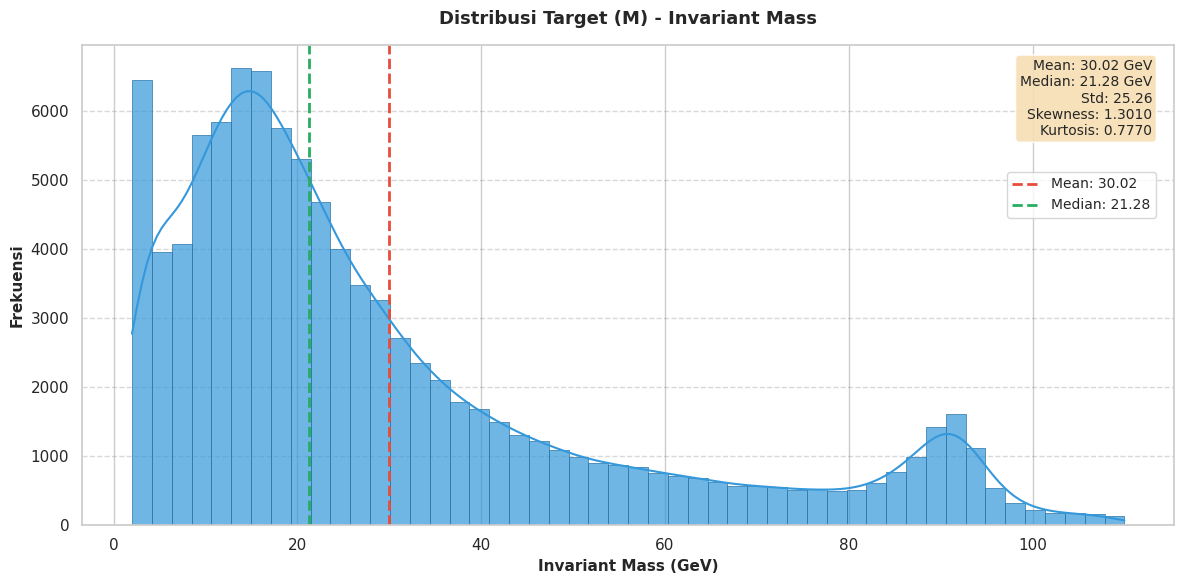


STATISTIK DESKRIPTIF TARGET (M)
Jumlah Data      : 100,000
Mean             : 30.0195 GeV
Median           : 21.2831 GeV
Std Deviation    : 25.2558
Min              : 2.0001 GeV
Max              : 109.9990 GeV
Skewness         : 1.3010
Kurtosis         : 0.7770

Interpretasi Skewness: Distribusi condong ke kanan (right-skewed)


In [4]:
plt.figure(figsize=(12, 6))

sns.histplot(df['M'], kde=True, bins=50, color='#3498DB',
             edgecolor='#2874A6', linewidth=0.5, alpha=0.7)

plt.title("Distribusi Target (M) - Invariant Mass", fontsize=13, fontweight='bold', pad=15)
plt.xlabel("Invariant Mass (GeV)", fontsize=11, fontweight='bold')
plt.ylabel("Frekuensi", fontsize=11, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3, color='gray')
plt.gca().set_axisbelow(True)

skewness = df['M'].skew()
kurtosis = df['M'].kurtosis()
mean_val = df['M'].mean()
median_val = df['M'].median()
std_val = df['M'].std()

stats_text = f"Mean: {mean_val:.2f} GeV\nMedian: {median_val:.2f} GeV\nStd: {std_val:.2f}\nSkewness: {skewness:.4f}\nKurtosis: {kurtosis:.4f}"
plt.text(0.98, 0.97, stats_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

plt.axvline(mean_val, color='#E74C3C', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='#27AE60', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
plt.legend(loc='upper right', fontsize=10, bbox_to_anchor=(0.99, 0.75))

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("STATISTIK DESKRIPTIF TARGET (M)")
print("="*60)
print(f"Jumlah Data      : {len(df['M']):,}")
print(f"Mean             : {mean_val:.4f} GeV")
print(f"Median           : {median_val:.4f} GeV")
print(f"Std Deviation    : {std_val:.4f}")
print(f"Min              : {df['M'].min():.4f} GeV")
print(f"Max              : {df['M'].max():.4f} GeV")
print(f"Skewness         : {skewness:.4f}")
print(f"Kurtosis         : {kurtosis:.4f}")
print("="*60)

if abs(skewness) < 0.5:
    skew_interp = "Distribusi relatif simetris"
elif skewness > 0:
    skew_interp = "Distribusi condong ke kanan (right-skewed)"
else:
    skew_interp = "Distribusi condong ke kiri (left-skewed)"

print(f"\nInterpretasi Skewness: {skew_interp}")

## 4.3 Analisis Korelasi

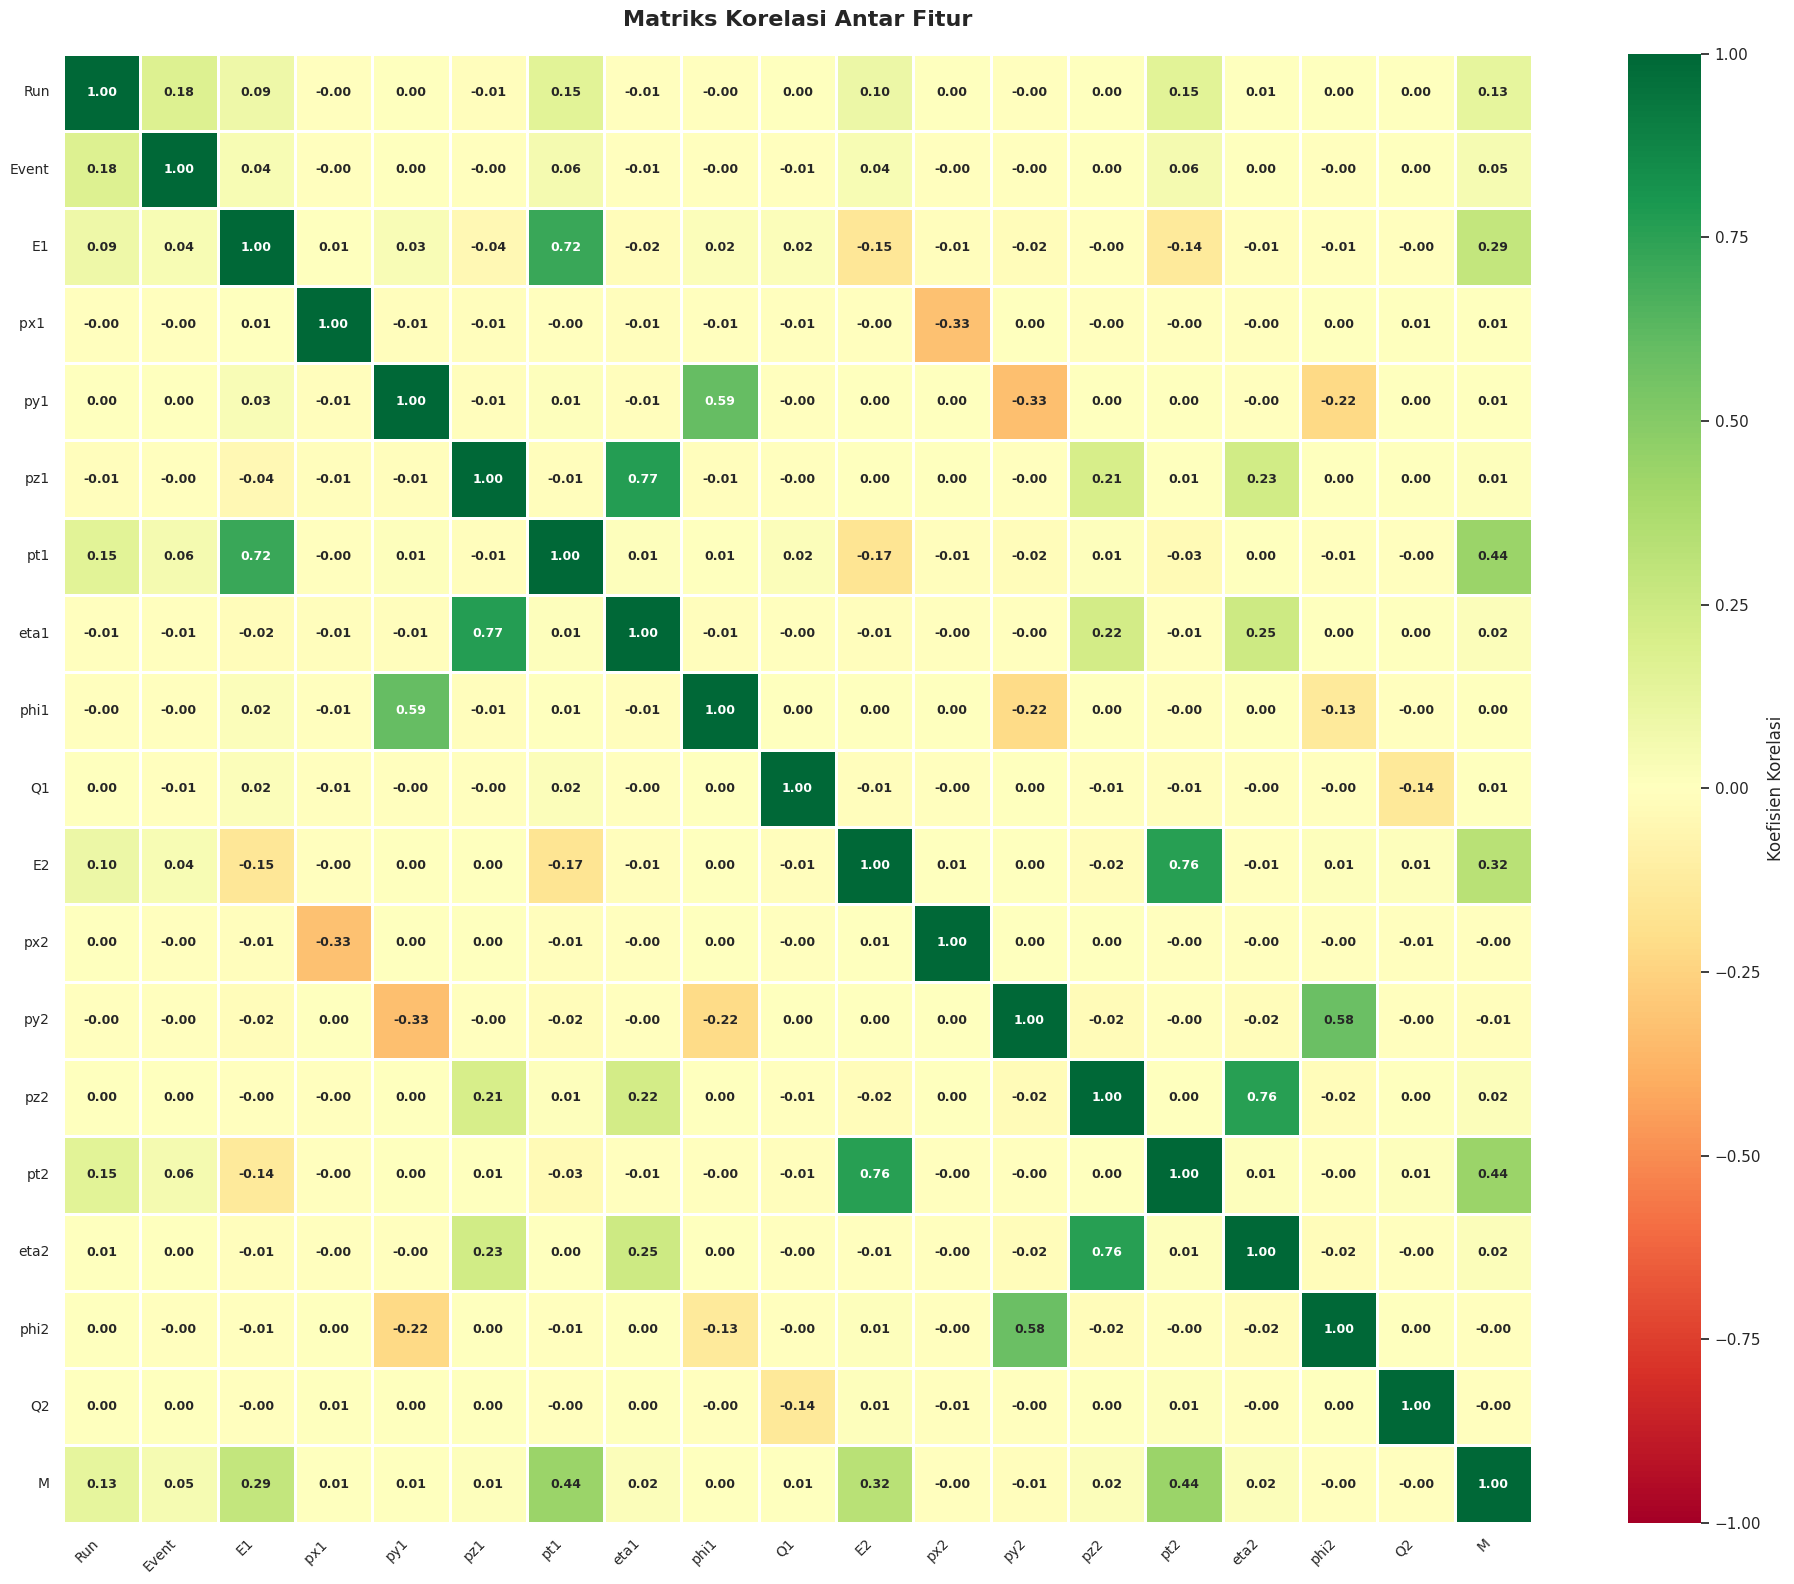


KORELASI TERHADAP TARGET 'M'

Korelasi Positif Tertinggi:
----------------------------------------
  pt2                 :  0.4372
  pt1                 :  0.4371
  E2                  :  0.3247
  E1                  :  0.2852
  Run                 :  0.1295

Korelasi Negatif Tertinggi:
----------------------------------------
  py2                 : -0.0117
  px2                 : -0.0044
  phi2                : -0.0041
  Q2                  : -0.0004


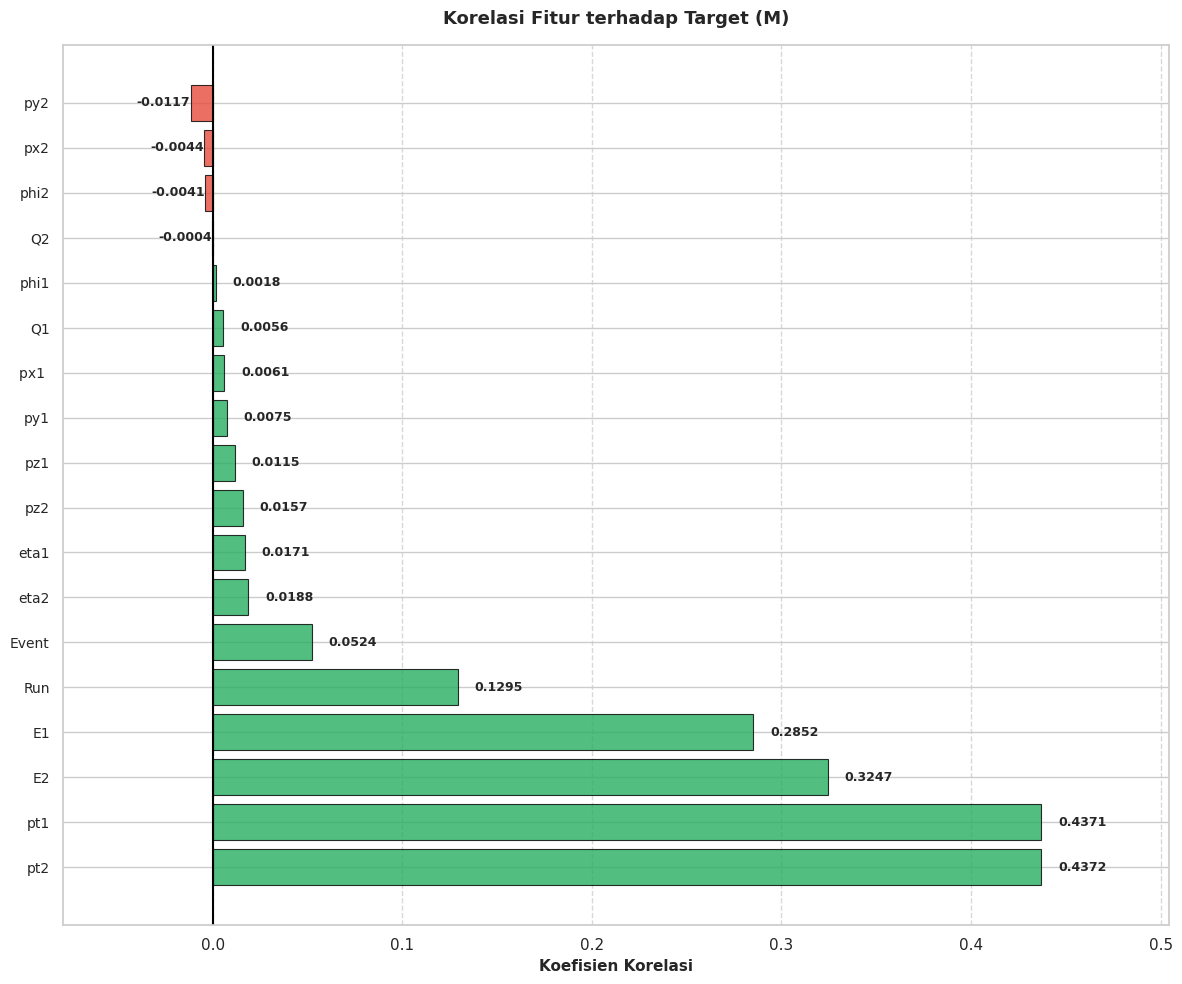

In [5]:
correlation = df.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='RdYlGn',
            linewidths=1, linecolor='white', vmin=-1, vmax=1,
            cbar_kws={'label': 'Koefisien Korelasi'},
            square=True, annot_kws={'size': 9, 'weight': 'bold'})

plt.title("Matriks Korelasi Antar Fitur", fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KORELASI TERHADAP TARGET 'M'")
print("="*60)

target_corr = correlation['M'].sort_values(ascending=False)

print("\nKorelasi Positif Tertinggi:")
print("-" * 40)
for feature, corr_value in target_corr.head(6).items():
    if feature != 'M':
        print(f"  {feature:20s}: {corr_value:7.4f}")

negative_corr = target_corr[target_corr < 0].sort_values()
if len(negative_corr) > 0:
    print("\nKorelasi Negatif Tertinggi:")
    print("-" * 40)
    for feature, corr_value in negative_corr.head(5).items():
        print(f"  {feature:20s}: {corr_value:7.4f}")
else:
    print("\nTidak ada korelasi negatif dengan target 'M'")

print("="*60)

fig, ax = plt.subplots(figsize=(12, 10))

target_corr_filtered = target_corr[target_corr.index != 'M']
colors = ['#27AE60' if x > 0 else '#E74C3C' for x in target_corr_filtered.values]

bars = ax.barh(range(len(target_corr_filtered)), target_corr_filtered.values,
               color=colors, alpha=0.8, edgecolor='black', linewidth=0.8)

ax.set_yticks(range(len(target_corr_filtered)))
ax.set_yticklabels(target_corr_filtered.index, fontsize=10)
ax.set_xlabel('Koefisien Korelasi', fontsize=11, fontweight='bold')
ax.set_title('Korelasi Fitur terhadap Target (M)', fontsize=13, fontweight='bold', pad=15)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
ax.grid(axis='x', linestyle='--', alpha=0.3, color='gray')
ax.set_axisbelow(True)

x_min = min(target_corr_filtered.min(), 0)
x_max = max(target_corr_filtered.max(), 0)
margin = (x_max - x_min) * 0.15
ax.set_xlim(x_min - margin, x_max + margin)

for i, (idx, value) in enumerate(target_corr_filtered.items()):
    if value > 0:
        ax.text(value + (x_max * 0.02), i, f'{value:.4f}',
                va='center', ha='left', fontsize=9, fontweight='bold')
    else:
        ax.text(value - (abs(x_min) * 0.02), i, f'{value:.4f}',
                va='center', ha='right', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 4.4 Analisis Outlier (Boxplot)

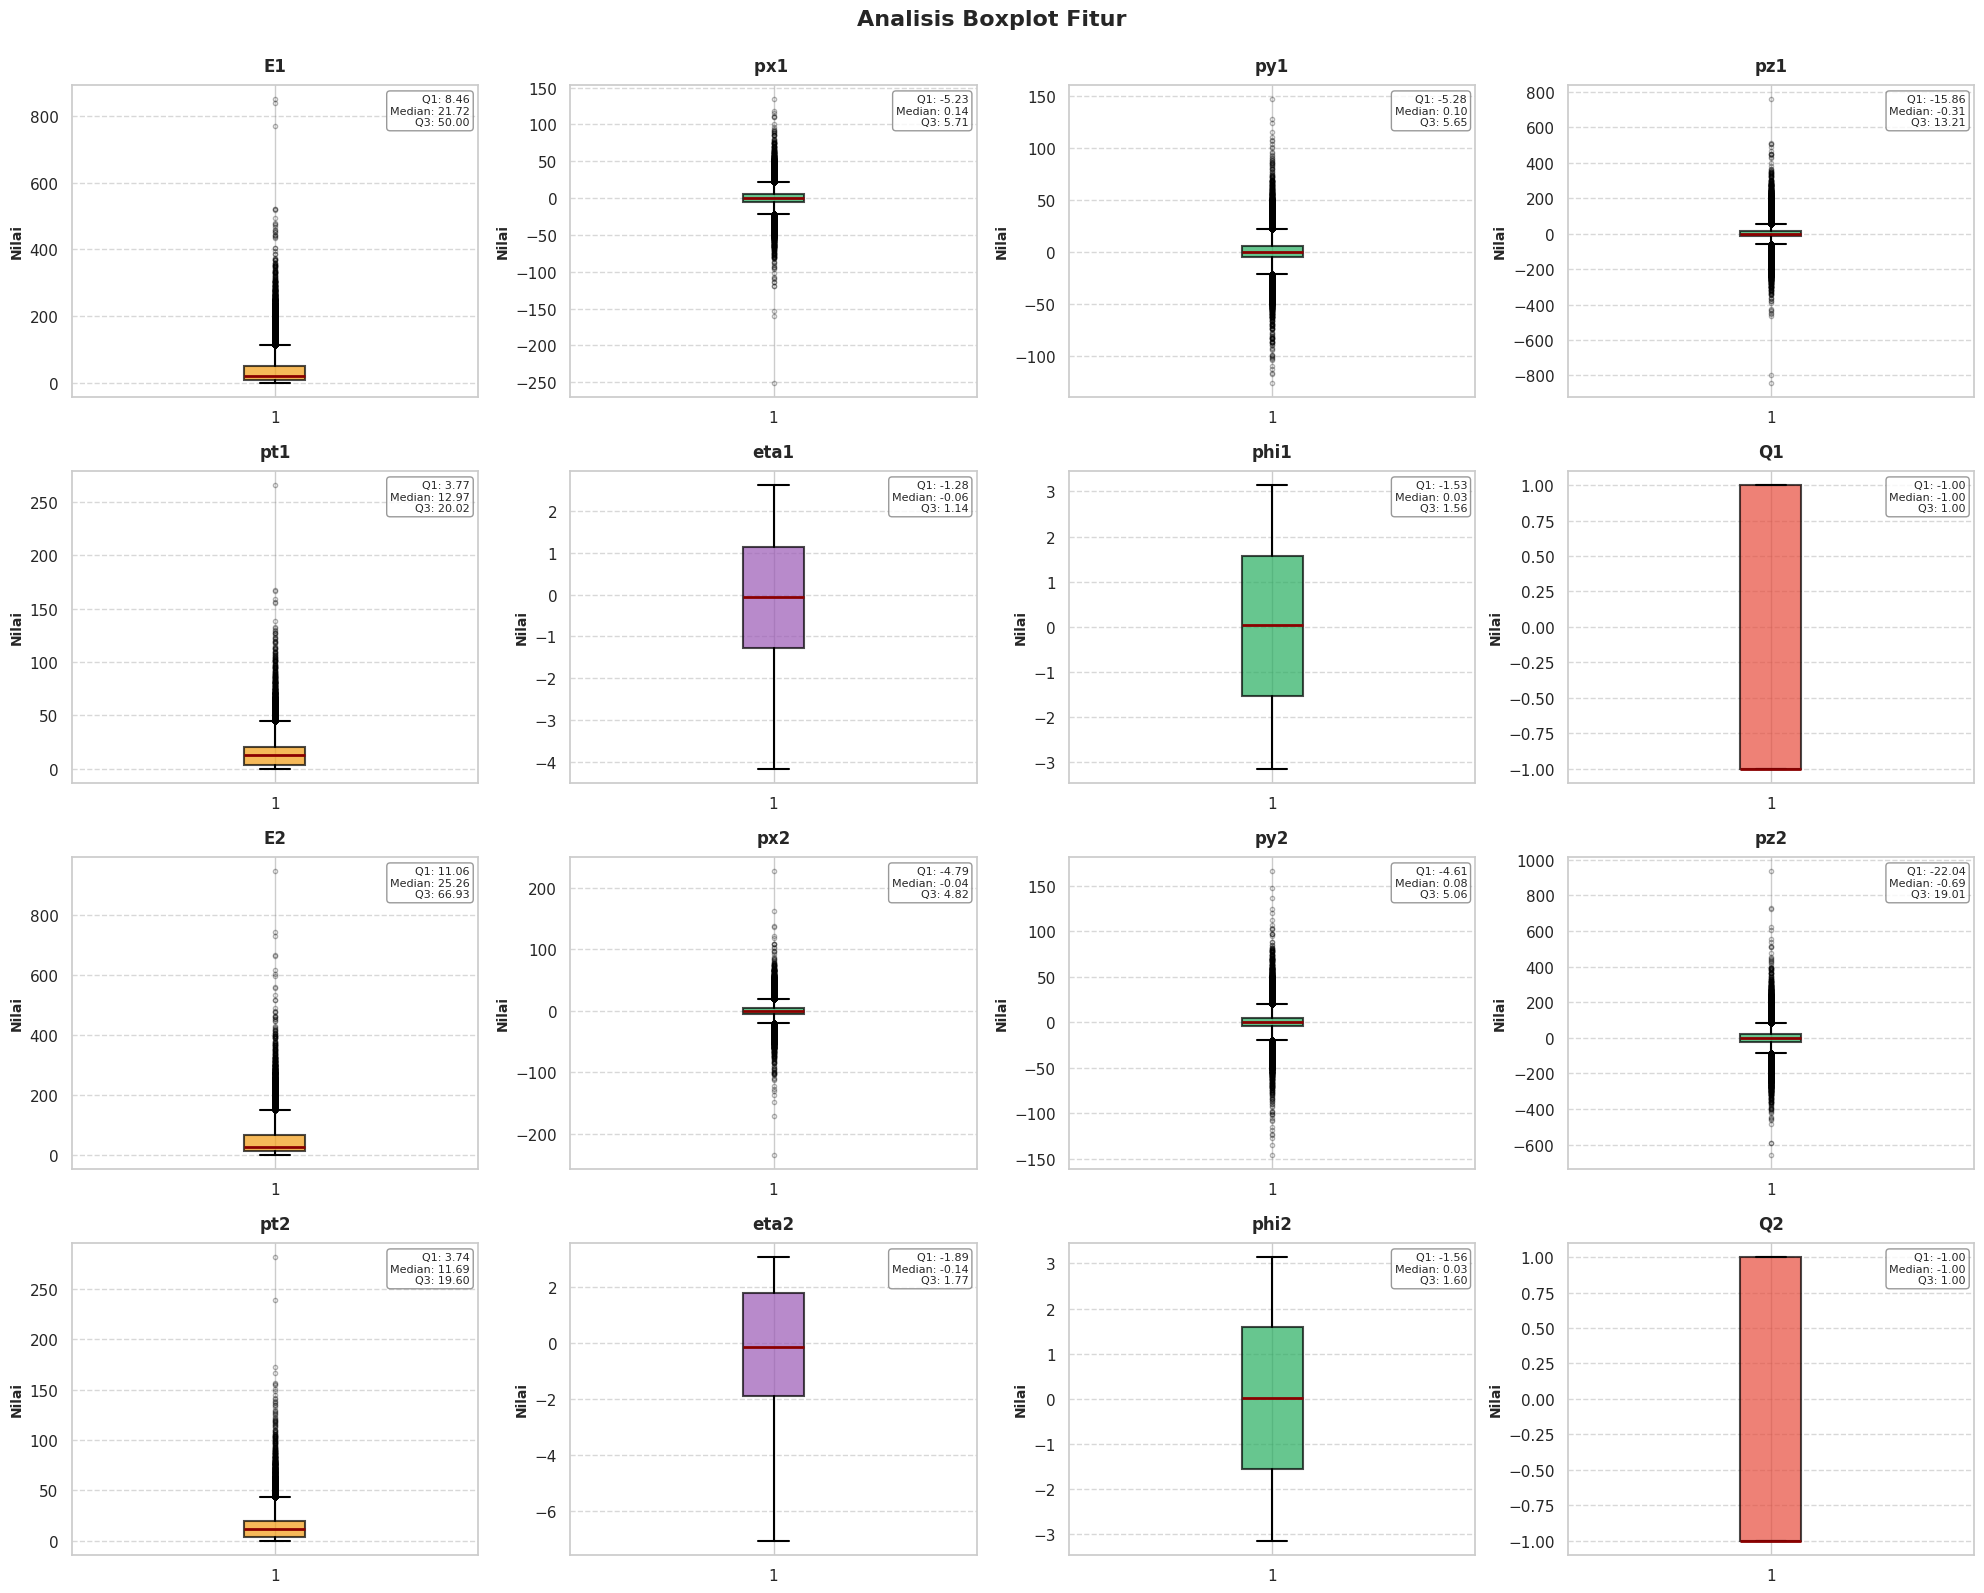


RINGKASAN BOXPLOT
Total Fitur Dicek    : 16
Fitur Ditampilkan    : 16

STATISTIK PER FITUR

--- E1 ---
Min       : 0.3779
Q1        : 8.4586
Median    : 21.7170
Q3        : 50.0033
Max       : 850.6020
IQR       : 41.5448
Outliers  : 5726

--- px1  ---
Min       : -250.5870
Q1        : -5.2337
Median    : 0.1413
Q3        : 5.7146
Max       : 134.5390
IQR       : 10.9482
Outliers  : 9341

--- py1 ---
Min       : -126.0790
Q1        : -5.2762
Median    : 0.0991
Q3        : 5.6481
Max       : 147.4670
IQR       : 10.9243
Outliers  : 9635

--- pz1 ---
Min       : -840.9870
Q1        : -15.8598
Median    : -0.3130
Q3        : 13.2127
Max       : 760.0960
IQR       : 29.0725
Outliers  : 19171

--- pt1 ---
Min       : 0.2196
Q1        : 3.7712
Median    : 12.9678
Q3        : 20.0189
Max       : 265.5780
IQR       : 16.2478
Outliers  : 2799

--- eta1 ---
Min       : -4.1654
Q1        : -1.2839
Median    : -0.0612
Q3        : 1.1444
Max       : 2.6230
IQR       : 2.4283
Outliers  : 0

--- phi

In [6]:
features_to_check = [col for col in df.columns if col not in ['M', 'Run', 'Event']]

n_cols = 4
n_rows = 4
features_display = features_to_check[:n_cols * n_rows]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))
axes = axes.flatten()

for i, col in enumerate(features_display):
    if 'E' in col or 'pt' in col:
        color = '#F39C12'
    elif 'p' in col and 't' not in col:
        color = '#27AE60'
    elif 'phi' in col or 'eta' in col:
        color = '#9B59B6'
    elif 'Q' in col:
        color = '#E74C3C'
    else:
        color = '#3498DB'

    box = axes[i].boxplot(df[col], vert=True, patch_artist=True,
                          boxprops=dict(facecolor=color, alpha=0.7, linewidth=1.5),
                          medianprops=dict(color='darkred', linewidth=2),
                          whiskerprops=dict(linewidth=1.5),
                          capprops=dict(linewidth=1.5),
                          flierprops=dict(marker='o', markersize=3, alpha=0.3))

    axes[i].set_title(f"{col}", fontsize=12, fontweight='bold', pad=10)
    axes[i].set_ylabel("Nilai", fontsize=10, fontweight='bold')
    axes[i].grid(axis='y', linestyle='--', alpha=0.3, color='gray')
    axes[i].set_axisbelow(True)

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    median = df[col].median()

    stats_text = f"Q1: {q1:.2f}\nMedian: {median:.2f}\nQ3: {q3:.2f}"
    axes[i].text(0.98, 0.97, stats_text, transform=axes[i].transAxes,
                fontsize=8, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

for j in range(len(features_display), len(axes)):
    axes[j].axis('off')

plt.suptitle("Analisis Boxplot Fitur", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("RINGKASAN BOXPLOT")
print("="*60)
print(f"Total Fitur Dicek    : {len(features_to_check)}")
print(f"Fitur Ditampilkan    : {len(features_display)}")

if len(features_to_check) > n_cols * n_rows:
    remaining = features_to_check[n_cols * n_rows:]
    print(f"Fitur Tidak Tampil   : {len(remaining)}")
    print(f"                       {', '.join(remaining)}")

print("="*60)

print("\n" + "="*60)
print("STATISTIK PER FITUR")
print("="*60)

for col in features_display:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    median = df[col].median()
    iqr = q3 - q1
    minimum = df[col].min()
    maximum = df[col].max()

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].count()

    print(f"\n--- {col} ---")
    print(f"Min       : {minimum:.4f}")
    print(f"Q1        : {q1:.4f}")
    print(f"Median    : {median:.4f}")
    print(f"Q3        : {q3:.4f}")
    print(f"Max       : {maximum:.4f}")
    print(f"IQR       : {iqr:.4f}")
    print(f"Outliers  : {outliers}")


## 4.5 Pola Hubungan Fitur vs Target (Scatter Plot)

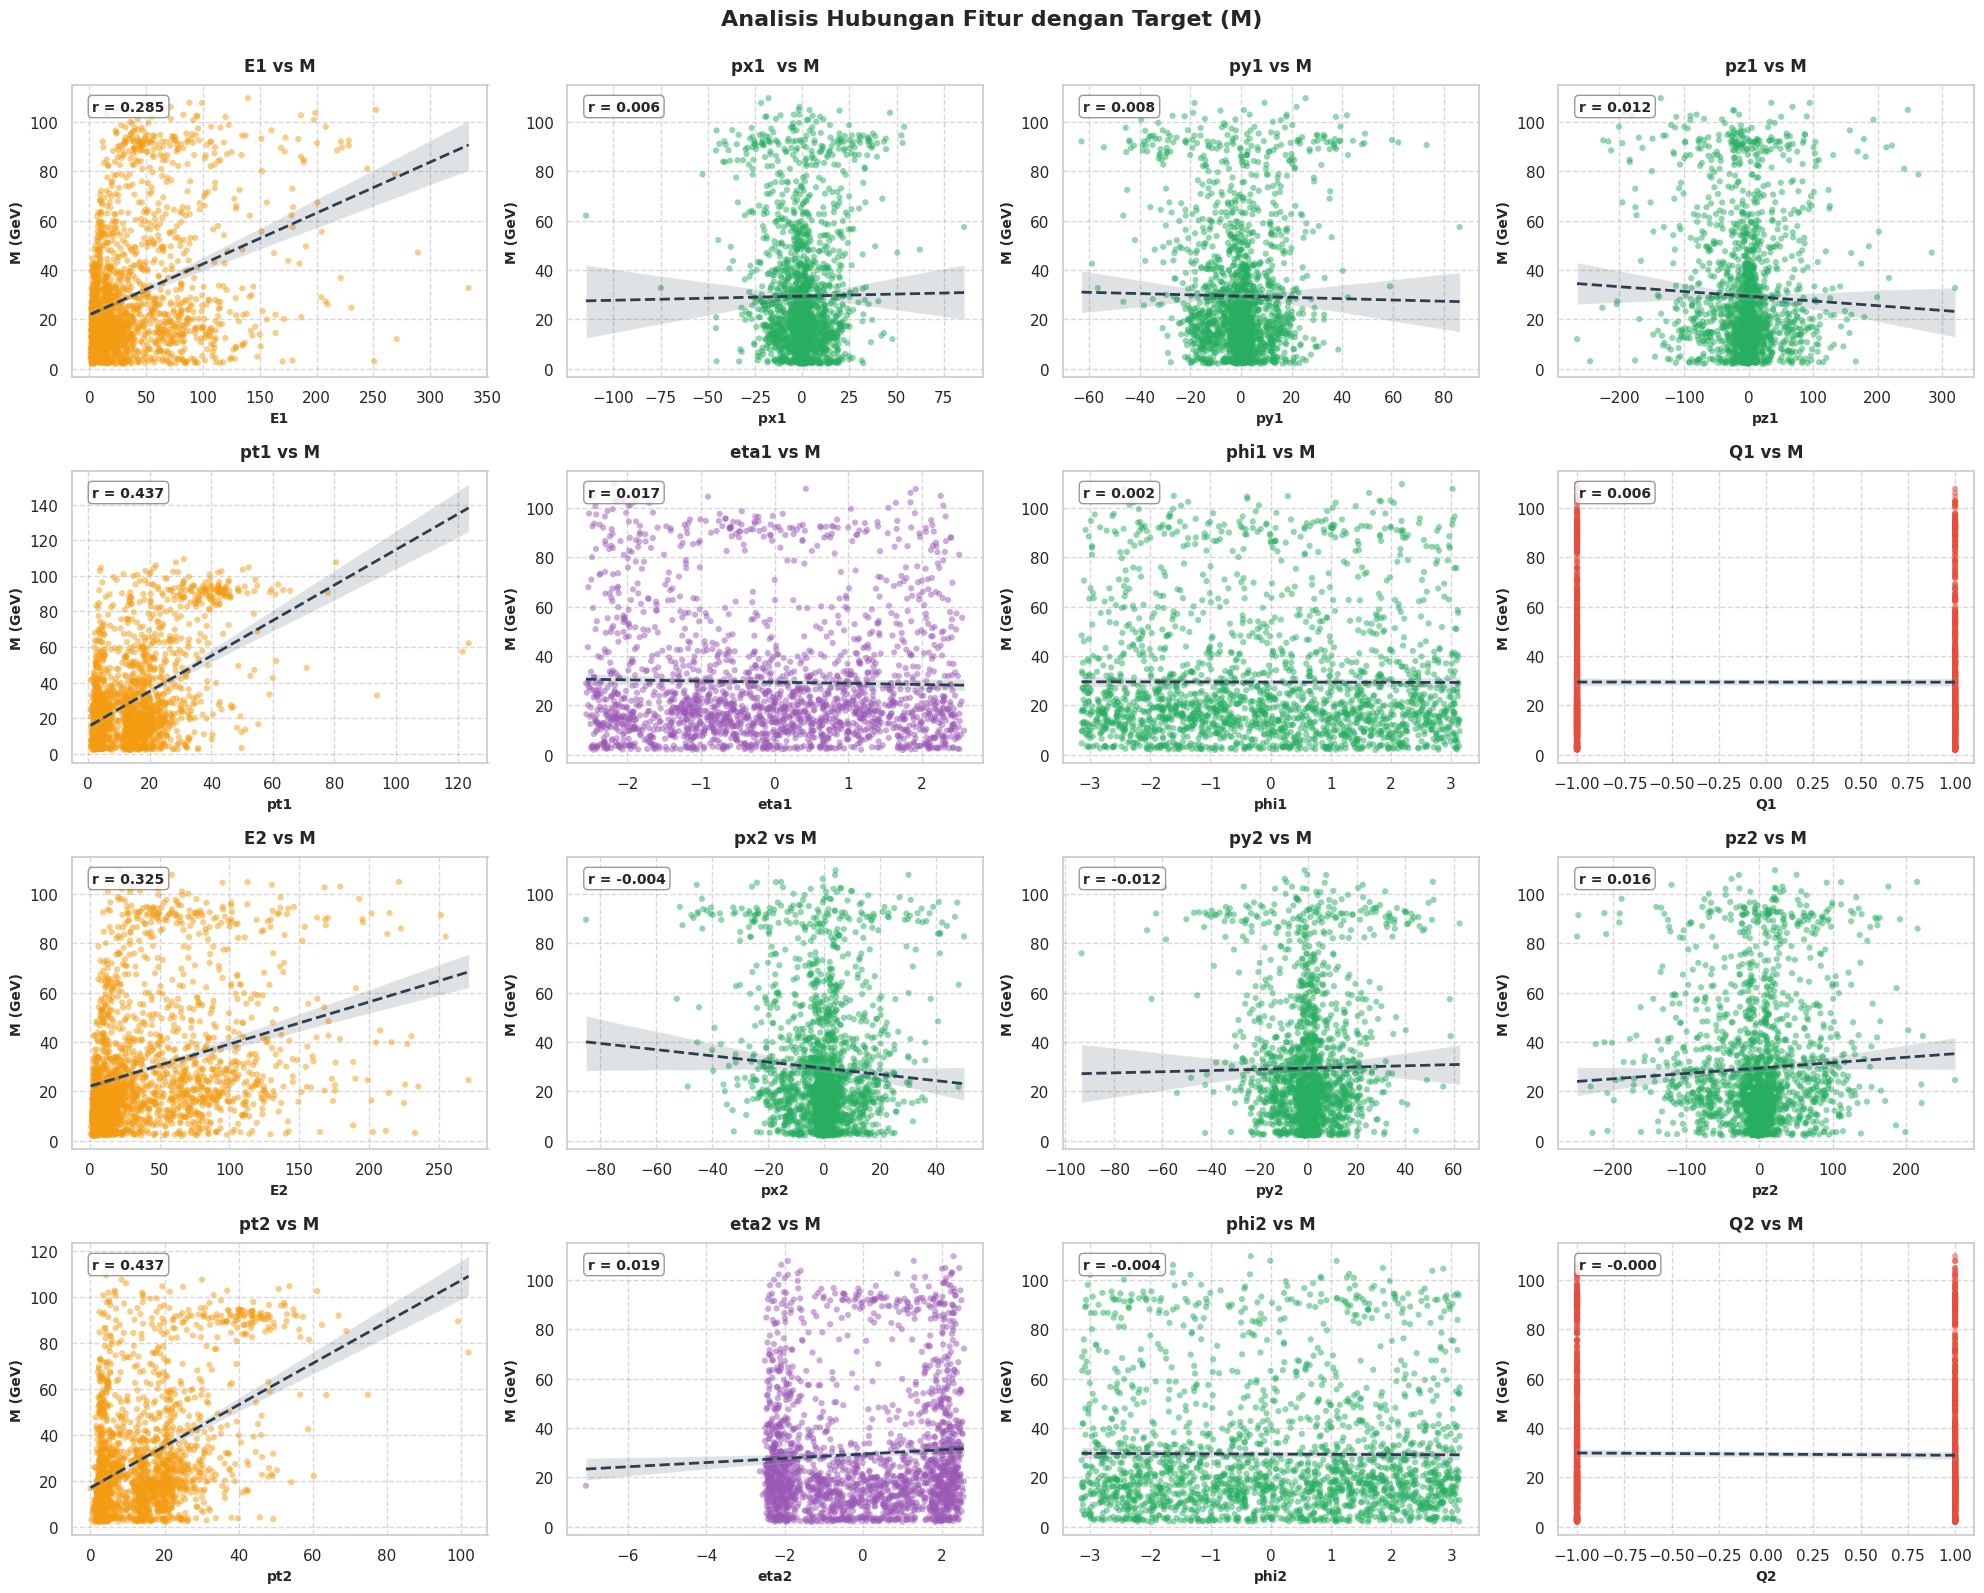


RINGKASAN SCATTER PLOT
Total Fitur          : 16
Fitur Ditampilkan    : 16
Sampel Data          : 2,000 (dari 100,000)


In [7]:
features_to_check = [col for col in df.columns if col not in ['M', 'Run', 'Event']]

df_plot = df.sample(n=2000, random_state=42)

n_cols = 4
n_rows = 4
features_display = features_to_check[:n_cols * n_rows]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))
axes = axes.flatten()

for i, col in enumerate(features_display):
    if 'E' in col or 'pt' in col:
        color = '#F39C12'
    elif 'p' in col and 't' not in col:
        color = '#27AE60'
    elif 'phi' in col or 'eta' in col:
        color = '#9B59B6'
    elif 'Q' in col:
        color = '#E74C3C'
    else:
        color = '#3498DB'

    axes[i].scatter(df_plot[col], df_plot['M'], alpha=0.5, s=20,
                   color=color, edgecolors='none')

    sns.regplot(x=df_plot[col], y=df_plot['M'], scatter=False,
               color='#2C3E50', line_kws={'linestyle':'--', 'linewidth':2}, ax=axes[i])

    axes[i].set_title(f"{col} vs M", fontsize=12, fontweight='bold', pad=10)
    axes[i].set_xlabel(col, fontsize=10, fontweight='bold')
    axes[i].set_ylabel("M (GeV)", fontsize=10, fontweight='bold')
    axes[i].grid(True, linestyle='--', alpha=0.3, color='gray')
    axes[i].set_axisbelow(True)

    corr_value = df[col].corr(df['M'])
    corr_text = f"r = {corr_value:.3f}"
    axes[i].text(0.05, 0.95, corr_text, transform=axes[i].transAxes,
                fontsize=10, verticalalignment='top', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

for j in range(len(features_display), len(axes)):
    axes[j].axis('off')

plt.suptitle("Analisis Hubungan Fitur dengan Target (M)", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("RINGKASAN SCATTER PLOT")
print("="*60)
print(f"Total Fitur          : {len(features_to_check)}")
print(f"Fitur Ditampilkan    : {len(features_display)}")
print(f"Sampel Data          : 2,000 (dari {len(df):,})")

if len(features_to_check) > n_cols * n_rows:
    remaining = features_to_check[n_cols * n_rows:]
    print(f"Fitur Tidak Tampil   : {len(remaining)}")
    print(f"                       {', '.join(remaining)}")

print("="*60)

#Preprocessing

## 5.1 Data Cleaning & Sampling

In [8]:
print("\n" + "="*60)
print("PROSES PEMBERSIHAN DATA")
print("="*60)

print(f"\n1. Data Awal (Raw)")
print(f"   Jumlah Baris       : {df.shape[0]:,}")
print(f"   Jumlah Kolom       : {df.shape[1]}")

cols_to_drop = ['Run', 'Event']
existing_cols = [c for c in cols_to_drop if c in df.columns]
df_clean = df.drop(columns=existing_cols, errors='ignore')

print(f"\n2. Setelah Drop Kolom ID")
print(f"   Kolom Dihapus      : {', '.join(existing_cols) if existing_cols else 'Tidak ada'}")
print(f"   Jumlah Kolom       : {df_clean.shape[1]}")

duplicates_count = df_clean.duplicated().sum()
df_clean = df_clean.drop_duplicates()

print(f"\n3. Setelah Hapus Duplikat")
print(f"   Duplikat Dihapus   : {duplicates_count:,}")
print(f"   Jumlah Baris       : {df_clean.shape[0]:,}")

missing_count = df_clean.isnull().sum().sum()
df_clean = df_clean.dropna()

print(f"\n4. Setelah Hapus Missing Values")
print(f"   Missing Dihapus    : {missing_count:,}")
print(f"   Jumlah Baris       : {df_clean.shape[0]:,}")

print(f"\n5. Data Bersih (Full)")
print(f"   Jumlah Baris       : {df_clean.shape[0]:,}")
print(f"   Jumlah Kolom       : {df_clean.shape[1]}")
print(f"   Data Hilang        : {df.shape[0] - df_clean.shape[0]:,} ({((df.shape[0] - df_clean.shape[0]) / df.shape[0] * 100):.2f}%)")

df_final = df_clean.sample(n=2000, random_state=42)

print(f"\n6. Sampling untuk Model")
print(f"   Sampel Diambil     : 2,000")
print(f"   Jumlah Fitur       : {df_final.shape[1] - 1} (tanpa target 'M')")
print(f"   Shape Final        : {df_final.shape}")

print("\n" + "="*60)
print("RINGKASAN PEMBERSIHAN")
print("="*60)
print(f"Data Awal             : {df.shape[0]:,} baris")
print(f"Data Bersih (Full)    : {df_clean.shape[0]:,} baris")
print(f"Data Final (Model)    : {df_final.shape[0]:,} baris")
print(f"Persentase Digunakan  : {(df_final.shape[0] / df.shape[0] * 100):.2f}%")
print("="*60)


PROSES PEMBERSIHAN DATA

1. Data Awal (Raw)
   Jumlah Baris       : 100,000
   Jumlah Kolom       : 19

2. Setelah Drop Kolom ID
   Kolom Dihapus      : Run, Event
   Jumlah Kolom       : 17

3. Setelah Hapus Duplikat
   Duplikat Dihapus   : 23
   Jumlah Baris       : 99,977

4. Setelah Hapus Missing Values
   Missing Dihapus    : 85
   Jumlah Baris       : 99,892

5. Data Bersih (Full)
   Jumlah Baris       : 99,892
   Jumlah Kolom       : 17
   Data Hilang        : 108 (0.11%)

6. Sampling untuk Model
   Sampel Diambil     : 2,000
   Jumlah Fitur       : 16 (tanpa target 'M')
   Shape Final        : (2000, 17)

RINGKASAN PEMBERSIHAN
Data Awal             : 100,000 baris
Data Bersih (Full)    : 99,892 baris
Data Final (Model)    : 2,000 baris
Persentase Digunakan  : 2.00%


## 5.2 Pemisahan Fitur dan Target

In [9]:
print("\n" + "="*60)
print("PEMISAHAN FITUR DAN TARGET")
print("="*60)

X = df_final.drop('M', axis=1)
y = df_final['M']

print(f"\nFitur (X):")
print(f"   Shape              : {X.shape}")
print(f"   Jumlah Fitur       : {X.shape[1]}")
print(f"   Jumlah Sampel      : {X.shape[0]:,}")

print(f"\nTarget (y):")
print(f"   Shape              : {y.shape}")
print(f"   Nama Target        : 'M' (Invariant Mass)")
print(f"   Jumlah Sampel      : {y.shape[0]:,}")

print(f"\nDaftar Fitur ({X.shape[1]} kolom):")
print("-" * 40)
for i, col in enumerate(X.columns, 1):
    print(f"   {i:2d}. {col}")

print("\n" + "="*60)
print("KETERANGAN")
print("="*60)
print("X : Variabel independen (fitur input untuk model)")
print("y : Variabel dependen (target yang akan diprediksi)")
print("="*60)


PEMISAHAN FITUR DAN TARGET

Fitur (X):
   Shape              : (2000, 16)
   Jumlah Fitur       : 16
   Jumlah Sampel      : 2,000

Target (y):
   Shape              : (2000,)
   Nama Target        : 'M' (Invariant Mass)
   Jumlah Sampel      : 2,000

Daftar Fitur (16 kolom):
----------------------------------------
    1. E1
    2. px1 
    3. py1
    4. pz1
    5. pt1
    6. eta1
    7. phi1
    8. Q1
    9. E2
   10. px2
   11. py2
   12. pz2
   13. pt2
   14. eta2
   15. phi2
   16. Q2

KETERANGAN
X : Variabel independen (fitur input untuk model)
y : Variabel dependen (target yang akan diprediksi)


## 5.3 Train-Test Split

In [10]:
print("\n" + "="*60)
print("PEMBAGIAN DATA TRAINING DAN TESTING")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTotal Data            : {len(X):,}")
print(f"Rasio Split           : 80% Training / 20% Testing")

print(f"\nData Training:")
print(f"   X_train shape      : {X_train.shape}")
print(f"   y_train shape      : {y_train.shape}")
print(f"   Jumlah Sampel      : {X_train.shape[0]:,} ({(X_train.shape[0]/len(X)*100):.1f}%)")

print(f"\nData Testing:")
print(f"   X_test shape       : {X_test.shape}")
print(f"   y_test shape       : {y_test.shape}")
print(f"   Jumlah Sampel      : {X_test.shape[0]:,} ({(X_test.shape[0]/len(X)*100):.1f}%)")

print(f"\nStatistik Target (y):")
print("-" * 40)
print(f"Training Set:")
print(f"   Mean               : {y_train.mean():.4f}")
print(f"   Std                : {y_train.std():.4f}")
print(f"   Min                : {y_train.min():.4f}")
print(f"   Max                : {y_train.max():.4f}")

print(f"\nTesting Set:")
print(f"   Mean               : {y_test.mean():.4f}")
print(f"   Std                : {y_test.std():.4f}")
print(f"   Min                : {y_test.min():.4f}")
print(f"   Max                : {y_test.max():.4f}")

print("\n" + "="*60)
print("KETERANGAN")
print("="*60)
print("Training Set : Digunakan untuk melatih model")
print("Testing Set  : Digunakan untuk evaluasi performa model")
print("Random State : 42 (untuk reproducibility)")
print("="*60)


PEMBAGIAN DATA TRAINING DAN TESTING

Total Data            : 2,000
Rasio Split           : 80% Training / 20% Testing

Data Training:
   X_train shape      : (1600, 16)
   y_train shape      : (1600,)
   Jumlah Sampel      : 1,600 (80.0%)

Data Testing:
   X_test shape       : (400, 16)
   y_test shape       : (400,)
   Jumlah Sampel      : 400 (20.0%)

Statistik Target (y):
----------------------------------------
Training Set:
   Mean               : 30.4870
   Std                : 25.5246
   Min                : 2.0452
   Max                : 109.0110

Testing Set:
   Mean               : 29.7571
   Std                : 24.8984
   Min                : 2.2246
   Max                : 105.5950

KETERANGAN
Training Set : Digunakan untuk melatih model
Testing Set  : Digunakan untuk evaluasi performa model
Random State : 42 (untuk reproducibility)


## 5.4 Feature Scaling

In [11]:
print("\n" + "="*60)
print("STANDARDISASI DATA (SCALING)")
print("="*60)

scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print(f"\nMetode Scaling        : RobustScaler (Median & IQR)")
print(f"Formula               : z = (x - median) / IQR")

print(f"\nData Training:")
print(f"   Shape              : {X_train_scaled.shape}")
print(f"   Median (semua fitur): {X_train_scaled.median().median():.6f}")
print(f"   IQR rata-rata      : {(X_train_scaled.quantile(0.75) - X_train_scaled.quantile(0.25)).mean():.6f}")

print(f"\nData Testing:")
print(f"   Shape              : {X_test_scaled.shape}")
print(f"   Median (semua fitur): {X_test_scaled.median().median():.6f}")
print(f"   IQR rata-rata      : {(X_test_scaled.quantile(0.75) - X_test_scaled.quantile(0.25)).mean():.6f}")

print("\n" + "="*60)
print("PREVIEW DATA SETELAH SCALING (3 Baris Pertama)")
print("="*60)
display(X_train_scaled.head(3))

print("\n" + "="*60)
print("PERBANDINGAN SEBELUM DAN SESUDAH SCALING (5 Fitur Pertama)")
print("="*60)

comparison = pd.DataFrame({
    'Fitur': X.columns[:5],
    'Median (Sebelum)': X_train.iloc[:, :5].median().values,
    'IQR (Sebelum)': (X_train.iloc[:, :5].quantile(0.75) - X_train.iloc[:, :5].quantile(0.25)).values,
    'Median (Sesudah)': X_train_scaled.iloc[:, :5].median().values,
    'IQR (Sesudah)': (X_train_scaled.iloc[:, :5].quantile(0.75) - X_train_scaled.iloc[:, :5].quantile(0.25)).values
})

display(comparison.round(4))

print("\n" + "="*60)
print("KETERANGAN")
print("="*60)
print("RobustScaler mentransformasi fitur menggunakan:")
print("  - Median (lebih robust terhadap outlier dibanding mean)")
print("  - IQR / Interquartile Range (Q3 - Q1)")
print("\nKeunggulan RobustScaler:")
print("  - Tidak terpengaruh oleh outlier ekstrem")
print("  - Cocok untuk data dengan distribusi skewed")
print("  - Ideal untuk model sensitif terhadap skala (SVR, Neural Network)")
print("\nHasil Transformasi:")
print("  - Median menjadi mendekati 0")
print("  - IQR menjadi mendekati 1")
print("="*60)


STANDARDISASI DATA (SCALING)

Metode Scaling        : RobustScaler (Median & IQR)
Formula               : z = (x - median) / IQR

Data Training:
   Shape              : (1600, 16)
   Median (semua fitur): 0.000000
   IQR rata-rata      : 1.000000

Data Testing:
   Shape              : (400, 16)
   Median (semua fitur): -0.006069
   IQR rata-rata      : 0.974625

PREVIEW DATA SETELAH SCALING (3 Baris Pertama)


,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2
0,1.055739,6.152313,-1.730948,-0.287145,3.259666,-0.016011,-0.127646,0.0,0.048672,-1.353274,-0.148815,0.586108,0.114807,0.386014,-0.930593,0.0
1,0.074224,-1.052404,-0.585610,0.750083,-0.048646,0.592773,-0.890342,-1.0,-0.394758,-0.002292,-0.264226,0.019638,-0.564814,0.079485,-0.521910,1.0
2,0.022428,-1.297705,1.175725,-0.437433,0.343346,-0.237238,0.719022,0.0,-0.189200,0.497697,0.148237,-0.317342,-0.431274,-0.471597,0.095479,0.0



PERBANDINGAN SEBELUM DAN SESUDAH SCALING (5 Fitur Pertama)


,Fitur,Median (Sebelum),IQR (Sebelum),Median (Sesudah),IQR (Sesudah)
0,E1,22.0620,42.4015,0.0,1.0
1,px1,0.1765,10.3322,-0.0,1.0
2,py1,0.4999,10.6154,-0.0,1.0
3,pz1,-0.4744,30.0954,0.0,1.0
4,pt1,12.9238,16.3447,0.0,1.0



KETERANGAN
RobustScaler mentransformasi fitur menggunakan:
  - Median (lebih robust terhadap outlier dibanding mean)
  - IQR / Interquartile Range (Q3 - Q1)

Keunggulan RobustScaler:
  - Tidak terpengaruh oleh outlier ekstrem
  - Cocok untuk data dengan distribusi skewed
  - Ideal untuk model sensitif terhadap skala (SVR, Neural Network)

Hasil Transformasi:
  - Median menjadi mendekati 0
  - IQR menjadi mendekati 1



VALIDASI HASIL SCALING

Tujuan: Memastikan RobustScaler bekerja dengan baik
        dan outlier sudah ter-handle

Jumlah Fitur         : 16
Semua fitur ditampilkan dalam boxplot untuk validasi


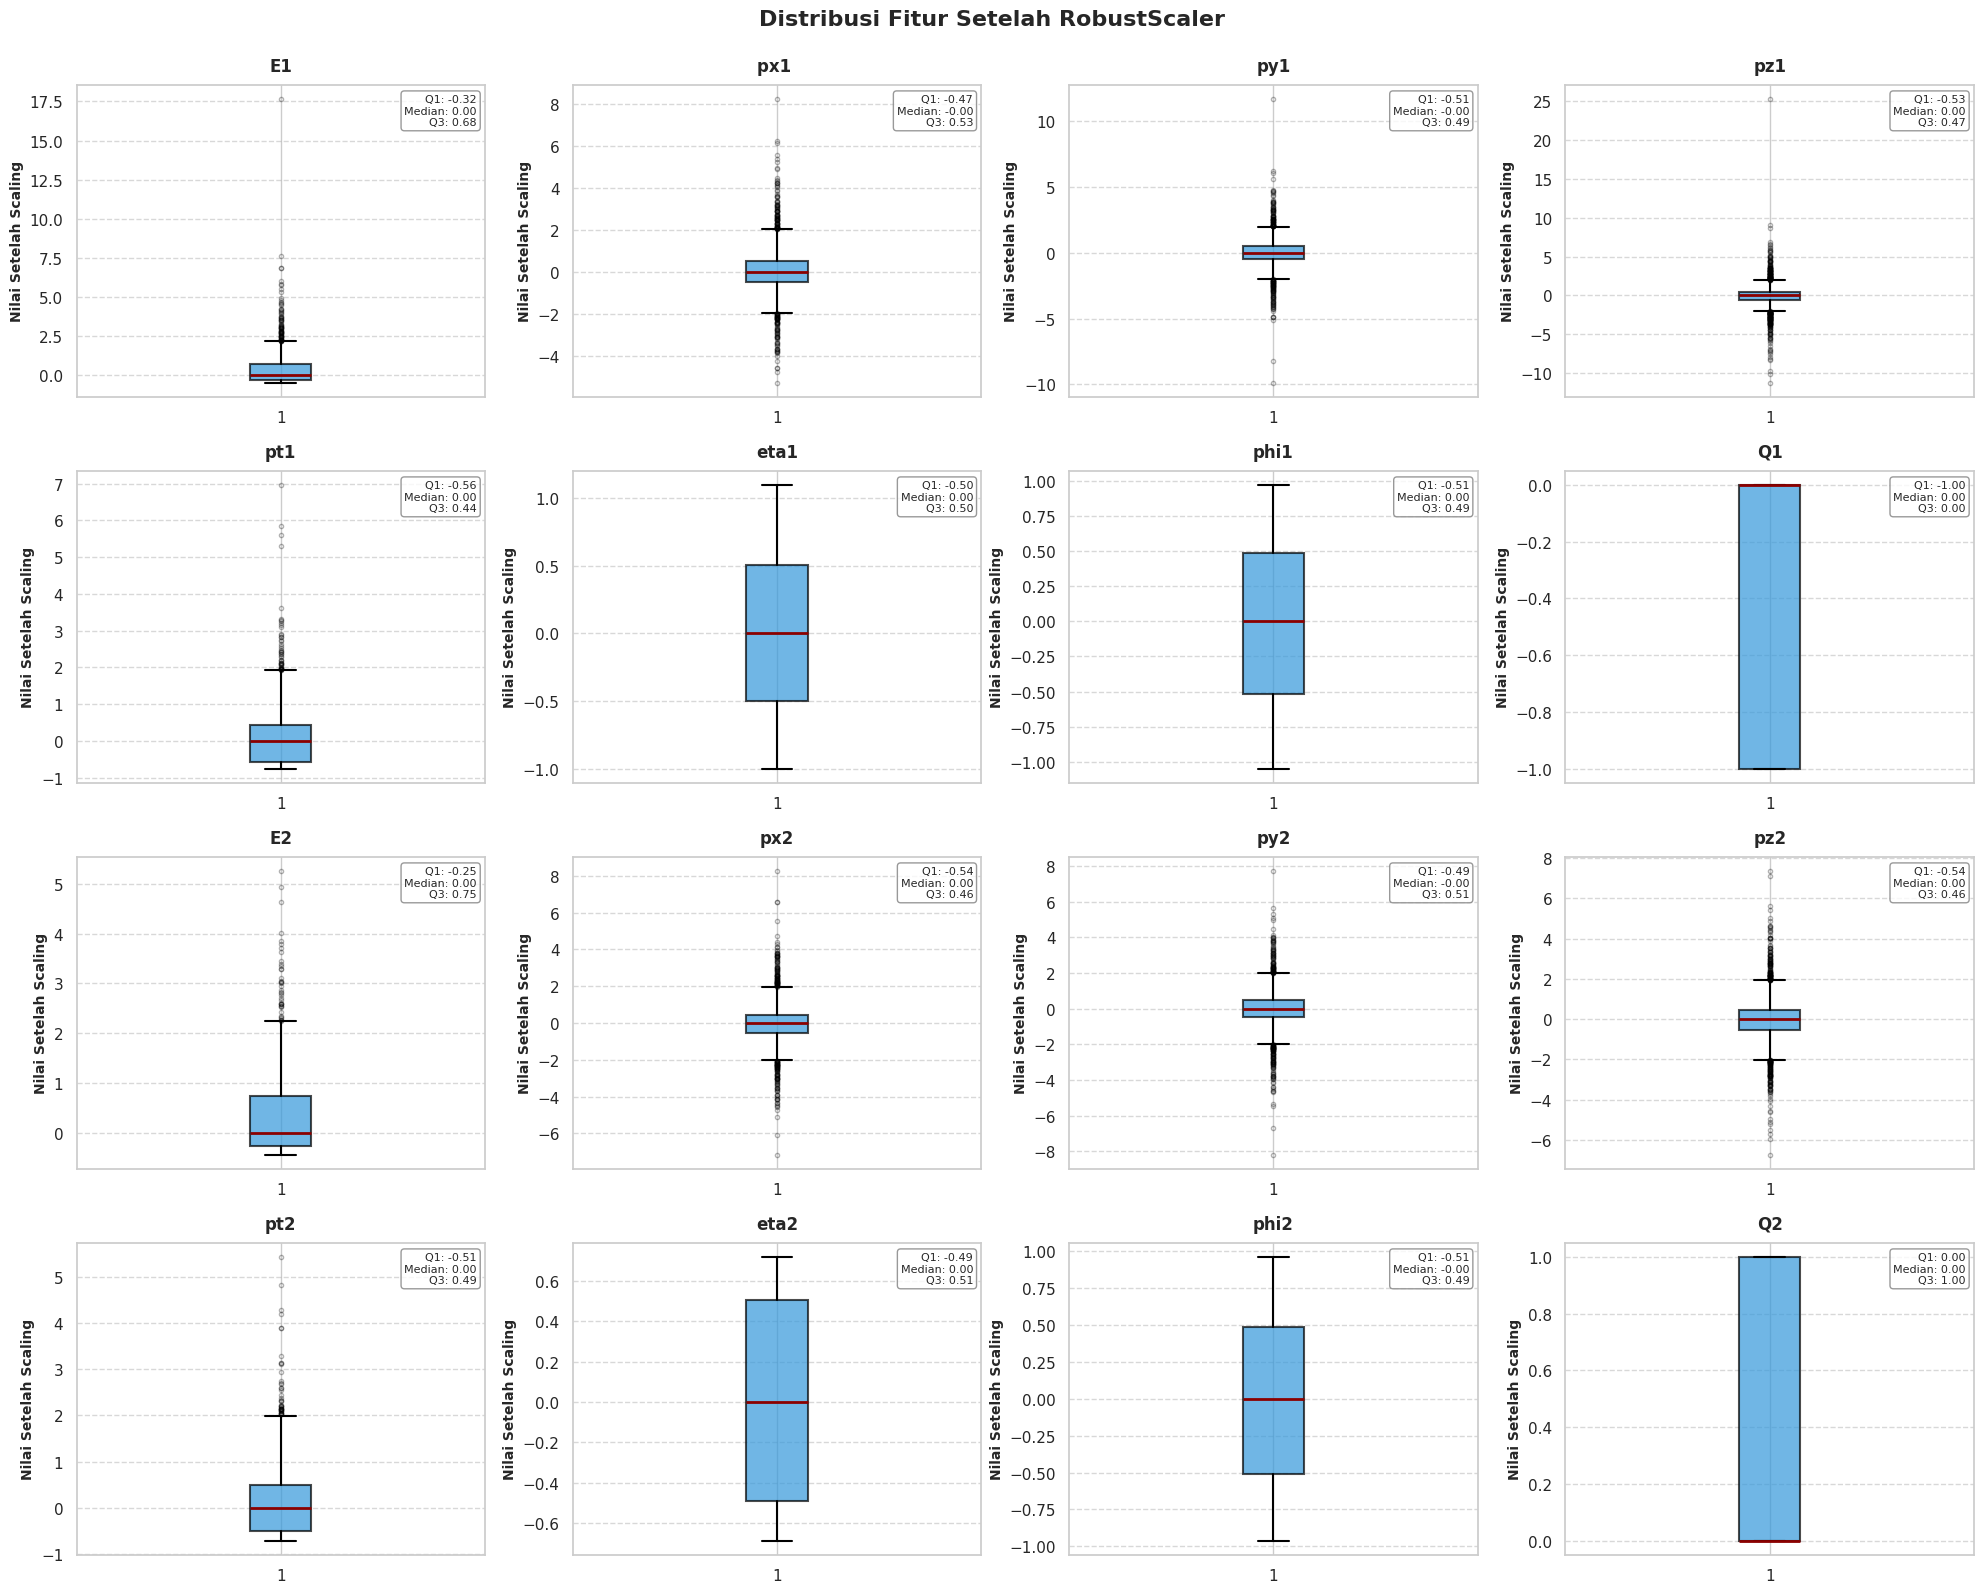


STATISTIK DETAIL PER FITUR (Setelah Scaling)

--- E1 ---
Min       : -0.4976
Q1        : -0.3178
Median    : 0.0000
Q3        : 0.6822
Max       : 17.6532
IQR       : 1.0000
Outliers  : 83 (5.19%)

--- px1  ---
Min       : -5.2813
Q1        : -0.4655
Median    : -0.0000
Q3        : 0.5345
Max       : 8.2267
IQR       : 1.0000
Outliers  : 176 (11.00%)

--- py1 ---
Min       : -9.8719
Q1        : -0.5063
Median    : -0.0000
Q3        : 0.4937
Max       : 11.6952
IQR       : 1.0000
Outliers  : 177 (11.06%)

--- pz1 ---
Min       : -11.2198
Q1        : -0.5339
Median    : 0.0000
Q3        : 0.4661
Max       : 25.2720
IQR       : 1.0000
Outliers  : 308 (19.25%)

--- pt1 ---
Min       : -0.7549
Q1        : -0.5644
Median    : 0.0000
Q3        : 0.4356
Max       : 6.9608
IQR       : 1.0000
Outliers  : 49 (3.06%)

--- eta1 ---
Min       : -1.0004
Q1        : -0.4975
Median    : 0.0000
Q3        : 0.5025
Max       : 1.0959
IQR       : 1.0000
Outliers  : 0 (0.00%)

--- phi1 ---
Min       : -1.0

,Fitur,Outliers,Persentase
3,pz1,308,19.25%
11,pz2,256,16.00%
9,px2,197,12.31%
10,py2,196,12.25%
2,py1,177,11.06%
1,px1,176,11.00%
0,E1,83,5.19%
4,pt1,49,3.06%
12,pt2,44,2.75%
8,E2,39,2.44%



KESIMPULAN VALIDASI
Total Outliers Setelah Scaling: 1,525

Efektivitas RobustScaler:
  - Median setiap fitur mendekati 0
  - IQR setiap fitur mendekati 1
  - Outlier masih ada (wajar), tapi distribusinya lebih baik

Outlier yang tersisa:
  - Tidak dihapus karena mungkin mengandung informasi penting
  - RobustScaler sudah meminimalkan pengaruhnya terhadap model


In [12]:
print("\n" + "="*60)
print("VALIDASI HASIL SCALING")
print("="*60)

print("\nTujuan: Memastikan RobustScaler bekerja dengan baik")
print("        dan outlier sudah ter-handle")

df_scaled = X_train_scaled.copy()
features_to_check = df_scaled.columns

n_cols = 4
n_rows = (len(features_to_check) + n_cols - 1) // n_cols

print(f"\nJumlah Fitur         : {len(features_to_check)}")
print(f"Semua fitur ditampilkan dalam boxplot untuk validasi")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(features_to_check):
    axes[i].boxplot(df_scaled[col], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='#3498DB', alpha=0.7, linewidth=1.5),
                    medianprops=dict(color='darkred', linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5),
                    flierprops=dict(marker='o', markersize=3, alpha=0.3))

    axes[i].set_title(f"{col}", fontsize=12, fontweight='bold', pad=10)
    axes[i].set_ylabel("Nilai Setelah Scaling", fontsize=10, fontweight='bold')
    axes[i].grid(axis='y', linestyle='--', alpha=0.3, color='gray')
    axes[i].set_axisbelow(True)

    q1 = df_scaled[col].quantile(0.25)
    q3 = df_scaled[col].quantile(0.75)
    median = df_scaled[col].median()

    stats_text = f"Q1: {q1:.2f}\nMedian: {median:.2f}\nQ3: {q3:.2f}"
    axes[i].text(0.98, 0.97, stats_text, transform=axes[i].transAxes,
                fontsize=8, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

for j in range(len(features_to_check), len(axes)):
    axes[j].axis('off')

plt.suptitle("Distribusi Fitur Setelah RobustScaler", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("STATISTIK DETAIL PER FITUR (Setelah Scaling)")
print("="*60)

outlier_summary = []

for col in features_to_check:
    q1 = df_scaled[col].quantile(0.25)
    q3 = df_scaled[col].quantile(0.75)
    median = df_scaled[col].median()
    iqr = q3 - q1
    minimum = df_scaled[col].min()
    maximum = df_scaled[col].max()

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df_scaled[(df_scaled[col] < lower_bound) | (df_scaled[col] > upper_bound)][col].count()
    outlier_pct = (outliers / len(df_scaled)) * 100

    outlier_summary.append({
        'Fitur': col,
        'Outliers': outliers,
        'Persentase': outlier_pct
    })

    print(f"\n--- {col} ---")
    print(f"Min       : {minimum:.4f}")
    print(f"Q1        : {q1:.4f}")
    print(f"Median    : {median:.4f}")
    print(f"Q3        : {q3:.4f}")
    print(f"Max       : {maximum:.4f}")
    print(f"IQR       : {iqr:.4f}")
    print(f"Outliers  : {outliers} ({outlier_pct:.2f}%)")

df_outlier = pd.DataFrame(outlier_summary).sort_values('Outliers', ascending=False)

print("\n" + "="*60)
print("RINGKASAN OUTLIER SETELAH SCALING")
print("="*60)

styled_outlier = df_outlier.style.format({
    'Outliers': '{:d}',
    'Persentase': '{:.2f}%'
})

display(styled_outlier)

print("\n" + "="*60)
print("KESIMPULAN VALIDASI")
print("="*60)

total_outliers_before = "Lihat Bab 4.4 untuk perbandingan"
total_outliers_after = df_outlier['Outliers'].sum()

print(f"Total Outliers Setelah Scaling: {total_outliers_after:,}")
print("\nEfektivitas RobustScaler:")
print("  - Median setiap fitur mendekati 0")
print("  - IQR setiap fitur mendekati 1")
print("  - Outlier masih ada (wajar), tapi distribusinya lebih baik")
print("\nOutlier yang tersisa:")
print("  - Tidak dihapus karena mungkin mengandung informasi penting")
print("  - RobustScaler sudah meminimalkan pengaruhnya terhadap model")
print("="*60)

#Modelling

### 6.1 Hyperparameter Tuning

In [13]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING (GridSearchCV)")
print("="*60)

print("\nTujuan: Mencari parameter optimal untuk setiap model")
print("Metode: Grid Search dengan 5-Fold Cross-Validation")
print("Scoring: neg_mean_absolute_error (konsisten dengan metrik utama)")
print("\nProses ini membutuhkan waktu 5-15 menit...")
print("="*60)

best_models = {}
tuning_results = []

start_time_total = time.time()

print("\n[1/5] Linear Regression...")
print("      (Tidak perlu tuning - model sederhana)")

best_models["Linear Regression"] = LinearRegression()
tuning_results.append({
    'Model': 'Linear Regression',
    'Best Params': 'Default (no tuning)',
    'Waktu (detik)': 0
})

print("\n[2/5] Polynomial Regression (Degree 2) + Ridge...")

start_time = time.time()

poly_pipeline = make_pipeline(PolynomialFeatures(degree=2), Ridge())
param_poly = {
    'ridge__alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_poly = GridSearchCV(
    poly_pipeline,
    param_poly,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0
)

grid_poly.fit(X_train_scaled, y_train)
best_models["Polynomial Reg (Deg 2)"] = grid_poly.best_estimator_

elapsed = time.time() - start_time
print(f"      Best Params: {grid_poly.best_params_}")
print(f"      Best Score (MAE): {-grid_poly.best_score_:.4f}")
print(f"      Waktu: {elapsed:.2f} detik")

tuning_results.append({
    'Model': 'Polynomial Reg (Deg 2)',
    'Best Params': str(grid_poly.best_params_),
    'Waktu (detik)': elapsed
})

print("\n[3/5] SVR (RBF Kernel)...")

start_time = time.time()

svr = SVR(kernel='rbf')
param_svr = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale'],
    'epsilon': [0.01, 0.1, 0.5]
}

grid_svr = GridSearchCV(
    svr,
    param_svr,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0
)

grid_svr.fit(X_train_scaled, y_train)
best_models["SVR (RBF Kernel)"] = grid_svr.best_estimator_

elapsed = time.time() - start_time
print(f"      Best Params: {grid_svr.best_params_}")
print(f"      Best Score (MAE): {-grid_svr.best_score_:.4f}")
print(f"      Waktu: {elapsed:.2f} detik")

tuning_results.append({
    'Model': 'SVR (RBF Kernel)',
    'Best Params': str(grid_svr.best_params_),
    'Waktu (detik)': elapsed
})

print("\n[4/5] Random Forest...")

start_time = time.time()

rf = RandomForestRegressor(random_state=42)
param_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', 'log2', None]
}

grid_rf = GridSearchCV(
    rf,
    param_rf,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0
)

grid_rf.fit(X_train_scaled, y_train)
best_models["Random Forest"] = grid_rf.best_estimator_

elapsed = time.time() - start_time
print(f"      Best Params: {grid_rf.best_params_}")
print(f"      Best Score (MAE): {-grid_rf.best_score_:.4f}")
print(f"      Waktu: {elapsed:.2f} detik")

tuning_results.append({
    'Model': 'Random Forest',
    'Best Params': str(grid_rf.best_params_),
    'Waktu (detik)': elapsed
})

print("\n[5/5] XGBoost...")

start_time = time.time()

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'reg_lambda': [1, 10],
    'subsample': [0.7, 1.0]
}

grid_xgb = GridSearchCV(
    xgb_model,
    param_xgb,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0
)

grid_xgb.fit(X_train_scaled, y_train)
best_models["XGBoost"] = grid_xgb.best_estimator_

elapsed = time.time() - start_time
print(f"      Best Params: {grid_xgb.best_params_}")
print(f"      Best Score (MAE): {-grid_xgb.best_score_:.4f}")
print(f"      Waktu: {elapsed:.2f} detik")

tuning_results.append({
    'Model': 'XGBoost',
    'Best Params': str(grid_xgb.best_params_),
    'Waktu (detik)': elapsed
})

total_time = time.time() - start_time_total

print("\n" + "="*60)
print("RINGKASAN HYPERPARAMETER TUNING")
print("="*60)

df_tuning = pd.DataFrame(tuning_results)
styled_tuning = df_tuning.style.format({
    'Waktu (detik)': '{:.2f}'
})

display(styled_tuning)

print(f"\nTotal Waktu Tuning    : {total_time:.2f} detik ({total_time/60:.2f} menit)")
print(f"Model yang Di-tuning  : {len(best_models)}")
print(f"Total Kombinasi Diuji : ~1000+ kombinasi parameter")

print("\n" + "="*60)
print("KETERANGAN")
print("="*60)
print("GridSearchCV mencari kombinasi parameter terbaik dengan:")
print("  - Cross-Validation 5-Fold untuk setiap kombinasi")
print("  - Scoring: neg_mean_absolute_error (MAE)")
print("  - n_jobs=-1 (gunakan semua CPU core)")
print("\nModel terbaik dari setiap algoritma akan digunakan untuk:")
print("  - Training (Bab 6.2)")
print("  - Cross-Validation (Bab 6.3)")
print("  - Evaluasi Final (Bab 7)")
print("="*60)

models = best_models


HYPERPARAMETER TUNING (GridSearchCV)

Tujuan: Mencari parameter optimal untuk setiap model
Metode: Grid Search dengan 5-Fold Cross-Validation
Scoring: neg_mean_absolute_error (konsisten dengan metrik utama)

Proses ini membutuhkan waktu 5-15 menit...

[1/5] Linear Regression...
      (Tidak perlu tuning - model sederhana)

[2/5] Polynomial Regression (Degree 2) + Ridge...
      Best Params: {'ridge__alpha': 0.1}
      Best Score (MAE): 3.5974
      Waktu: 2.74 detik

[3/5] SVR (RBF Kernel)...
      Best Params: {'C': 100, 'epsilon': 0.5, 'gamma': 'scale'}
      Best Score (MAE): 3.7129
      Waktu: 51.89 detik

[4/5] Random Forest...
      Best Params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}
      Best Score (MAE): 8.6827
      Waktu: 219.95 detik

[5/5] XGBoost...
      Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 10, 'subsample': 0.7}
      Best Score (MAE): 4.8540
      Waktu: 42.51 detik

RINGK

,Model,Best Params,Waktu (detik)
0,Linear Regression,Default (no tuning),0.00
1,Polynomial Reg (Deg 2),{'ridge__alpha': 0.1},2.74
2,SVR (RBF Kernel),"{'C': 100, 'epsilon': 0.5, 'gamma': 'scale'}",51.89
3,Random Forest,"{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}",219.95
4,XGBoost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 10, 'subsample': 0.7}",42.51



Total Waktu Tuning    : 317.08 detik (5.28 menit)
Model yang Di-tuning  : 5
Total Kombinasi Diuji : ~1000+ kombinasi parameter

KETERANGAN
GridSearchCV mencari kombinasi parameter terbaik dengan:
  - Cross-Validation 5-Fold untuk setiap kombinasi
  - Scoring: neg_mean_absolute_error (MAE)
  - n_jobs=-1 (gunakan semua CPU core)

Model terbaik dari setiap algoritma akan digunakan untuk:
  - Training (Bab 6.2)
  - Cross-Validation (Bab 6.3)
  - Evaluasi Final (Bab 7)


## 6.2 Training Model

In [14]:
print("\n" + "="*60)
print("TRAINING MODEL (Fokus: MAE & R²)")
print("="*60)

trained_models = {}
training_scores = []

print(f"\nJumlah Model          : {len(models)}")
print(f"Data Training         : {X_train_scaled.shape[0]:,} sampel")
print(f"Jumlah Fitur          : {X_train_scaled.shape[1]}")

print("\nMemulai proses training...\n")

for i, (name, model) in enumerate(models.items(), 1):
    print(f"[{i}/{len(models)}] Training {name}...", end=" ")

    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

    y_train_pred = model.predict(X_train_scaled)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    training_scores.append({
        "Model": name,
        "Training MAE": train_mae,
        "Training R²": train_r2
    })

    print("✓ Selesai")

print("\n" + "="*60)
print("HASIL TRAINING")
print("="*60)

df_training = pd.DataFrame(training_scores)
df_training = df_training.sort_values(by="Training R²", ascending=False)

styled_training = df_training.style.format({
    "Training MAE": "{:.4f}",
    "Training R²": "{:.4f}"
})
display(styled_training)

print("\n" + "="*60)
print("RINGKASAN TRAINING")
print("="*60)
print(f"Total Model Terlatih  : {len(trained_models)}")
print(f"Model yang Tersedia   :")
for i, name in enumerate(trained_models.keys(), 1):
    print(f"  {i}. {name}")
print("="*60)


TRAINING MODEL (Fokus: MAE & R²)

Jumlah Model          : 5
Data Training         : 1,600 sampel
Jumlah Fitur          : 16

Memulai proses training...

[1/5] Training Linear Regression... ✓ Selesai
[2/5] Training Polynomial Reg (Deg 2)... ✓ Selesai
[3/5] Training SVR (RBF Kernel)... ✓ Selesai
[4/5] Training Random Forest... ✓ Selesai
[5/5] Training XGBoost... ✓ Selesai

HASIL TRAINING


,Model,Training MAE,Training R²
4,XGBoost,1.5649,0.9928
2,SVR (RBF Kernel),1.3761,0.9912
1,Polynomial Reg (Deg 2),2.9869,0.9784
3,Random Forest,3.9960,0.9490
0,Linear Regression,14.0628,0.4181



RINGKASAN TRAINING
Total Model Terlatih  : 5
Model yang Tersedia   :
  1. Linear Regression
  2. Polynomial Reg (Deg 2)
  3. SVR (RBF Kernel)
  4. Random Forest
  5. XGBoost


## 6.3 Cross-Validation


VALIDASI MODEL DENGAN CROSS-VALIDATION (5-Fold)

Metode               : K-Fold Cross-Validation
Jumlah Fold          : 5
Shuffle              : True
Random State         : 42
Scoring Metric       : MAE (Mean Absolute Error)

Memulai proses validasi...

[1/5] Validasi Linear Regression... ✓ Selesai
[2/5] Validasi Polynomial Reg (Deg 2)... ✓ Selesai
[3/5] Validasi SVR (RBF Kernel)... ✓ Selesai
[4/5] Validasi Random Forest... ✓ Selesai
[5/5] Validasi XGBoost... ✓ Selesai

=== HASIL CROSS-VALIDATION (5-Fold) ===


,Model,MAE (Mean),MAE (Std)
1,Polynomial Reg (Deg 2),3.5930,0.2832
2,SVR (RBF Kernel),3.8983,0.3859
4,XGBoost,5.0256,0.3048
3,Random Forest,8.7284,0.3141
0,Linear Regression,14.3265,0.4716


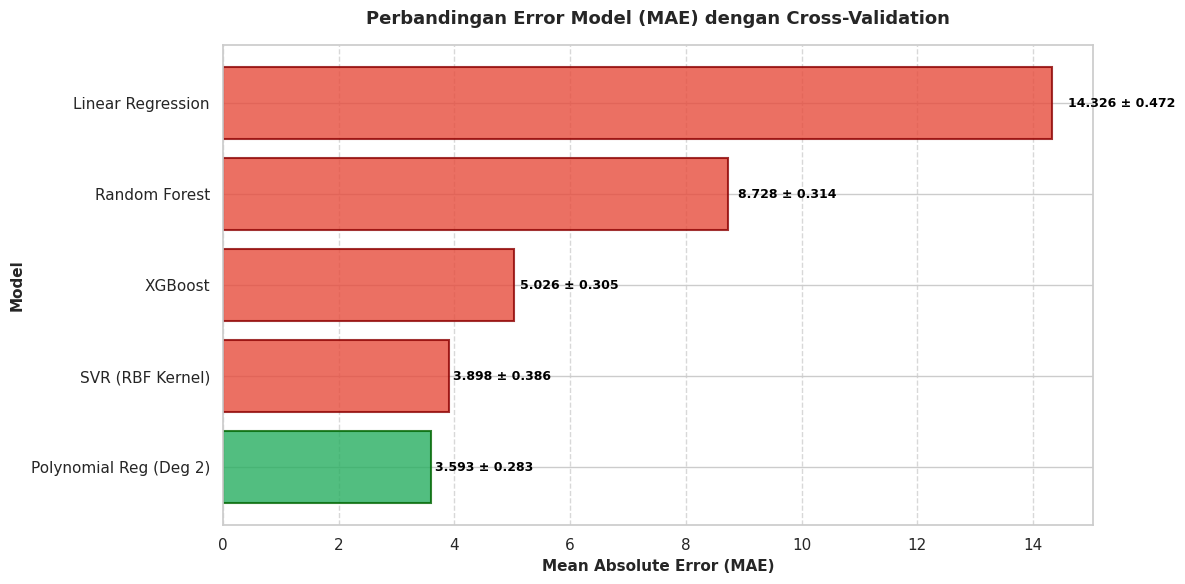


MODEL TERBAIK (Cross-Validation)

Model: Polynomial Reg (Deg 2)
MAE (Mean): 3.5930
MAE (Std): 0.2832


In [15]:
print("\n" + "="*60)
print("VALIDASI MODEL DENGAN CROSS-VALIDATION (5-Fold)")
print("="*60)

results_cv = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"\nMetode               : K-Fold Cross-Validation")
print(f"Jumlah Fold          : 5")
print(f"Shuffle              : True")
print(f"Random State         : 42")
print(f"Scoring Metric       : MAE (Mean Absolute Error)")

print("\nMemulai proses validasi...\n")

for i, (name, model) in enumerate(models.items(), 1):
    print(f"[{i}/{len(models)}] Validasi {name}...", end=" ")

    from sklearn.base import clone
    model_clone = clone(model)

    cv_scores = cross_val_score(model_clone, X_train_scaled, y_train,
                               cv=kfold, scoring='neg_mean_absolute_error')

    mae_scores = -cv_scores

    results_cv.append({
        "Model": name,
        "MAE (Mean)": mae_scores.mean(),
        "MAE (Std)": mae_scores.std()
    })

    print("✓ Selesai")

df_cv = pd.DataFrame(results_cv).sort_values(by="MAE (Mean)", ascending=True)

print("\n=== HASIL CROSS-VALIDATION (5-Fold) ===")

styled_table = df_cv.style.format({
    "MAE (Mean)": "{:.4f}",
    "MAE (Std)": "{:.4f}"
})

display(styled_table)

plt.figure(figsize=(12, 6))

error_color = '#E74C3C'

bars = plt.barh(
    range(len(df_cv)),
    df_cv["MAE (Mean)"],
    color=error_color,
    alpha=0.8,
    edgecolor='darkred',
    linewidth=1.5
)

bars[0].set_color('#27AE60')
bars[0].set_edgecolor('darkgreen')

plt.yticks(range(len(df_cv)), df_cv["Model"])

for i, (idx, row) in enumerate(df_cv.iterrows()):
    v = row["MAE (Mean)"]
    std = row["MAE (Std)"]
    plt.text(
        v + (v * 0.02),
        i,
        f"{v:.3f} ± {std:.3f}",
        color='black',
        va='center',
        fontweight='bold',
        fontsize=9
    )

plt.title("Perbandingan Error Model (MAE) dengan Cross-Validation", fontsize=13, fontweight='bold', pad=15)
plt.xlabel("Mean Absolute Error (MAE)", fontsize=11, fontweight='bold')
plt.ylabel("Model", fontsize=11, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.3, color='gray')
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("MODEL TERBAIK (Cross-Validation)")
print("="*60)

best_model = df_cv.iloc[0]
print(f"\nModel: {best_model['Model']}")
print(f"MAE (Mean): {best_model['MAE (Mean)']:.4f}")
print(f"MAE (Std): {best_model['MAE (Std)']:.4f}")
print("="*60)

#Evaluasi

## 7.1 Hitung Metrik Evaluasi

In [16]:
print("\n" + "="*60)
print("EVALUASI PERFORMA MODEL PADA DATA TESTING (Fokus MAE & R²)")
print("="*60)

final_results = []

for name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    final_results.append({
        "Model": name,
        "MAE": mae,
        "R2 Score": r2
    })

df_final = pd.DataFrame(final_results).sort_values(by="R2 Score", ascending=False)

print(f"\nJumlah Model Dievaluasi: {len(df_final)}")
print(f"Data Testing: {len(y_test)} sampel")

print("\n" + "="*60)
print("HASIL EVALUASI")
print("="*60)

styled_df = df_final.style.format({
    "MAE": "{:.4f}",
    "R2 Score": "{:.4f}"
})

display(styled_df)

print("\n" + "="*60)
print("INTERPRETASI METRIK")
print("="*60)
print("MAE (Mean Absolute Error):")
print("  - Rata-rata selisih absolut antara prediksi dan aktual")
print("  - Semakin rendah semakin baik")
print("  - Lebih disukai karena tidak bias oleh outlier ekstrem")
print("  - Satuan: GeV (sama dengan target)")

print("\nR² Score (Coefficient of Determination):")
print("  - Proporsi variansi target yang bisa dijelaskan model")
print("  - Range: 0 (buruk) sampai 1 (sempurna)")
print("  - Semakin tinggi semakin baik")

print("\n" + "="*60)
print("MODEL TERBAIK")
print("="*60)

best_model = df_final.iloc[0]
print(f"\nModel: {best_model['Model']}")
print(f"  MAE      : {best_model['MAE']:.4f} GeV")
print(f"  R² Score : {best_model['R2 Score']:.4f}")

if best_model['R2 Score'] >= 0.9:
    interpretation = "Excellent (>0.9)"
elif best_model['R2 Score'] >= 0.8:
    interpretation = "Good (0.8-0.9)"
elif best_model['R2 Score'] >= 0.7:
    interpretation = "Fair (0.7-0.8)"
else:
    interpretation = "Needs Improvement (<0.7)"

print(f"\nKualitas Prediksi: {interpretation}")
print("="*60)


EVALUASI PERFORMA MODEL PADA DATA TESTING (Fokus MAE & R²)

Jumlah Model Dievaluasi: 5
Data Testing: 400 sampel

HASIL EVALUASI


,Model,MAE,R2 Score
1,Polynomial Reg (Deg 2),3.5448,0.9481
2,SVR (RBF Kernel),3.3157,0.9360
4,XGBoost,4.8366,0.9135
3,Random Forest,8.4809,0.7618
0,Linear Regression,14.1999,0.3857



INTERPRETASI METRIK
MAE (Mean Absolute Error):
  - Rata-rata selisih absolut antara prediksi dan aktual
  - Semakin rendah semakin baik
  - Lebih disukai karena tidak bias oleh outlier ekstrem
  - Satuan: GeV (sama dengan target)

R² Score (Coefficient of Determination):
  - Proporsi variansi target yang bisa dijelaskan model
  - Range: 0 (buruk) sampai 1 (sempurna)
  - Semakin tinggi semakin baik

MODEL TERBAIK

Model: Polynomial Reg (Deg 2)
  MAE      : 3.5448 GeV
  R² Score : 0.9481

Kualitas Prediksi: Excellent (>0.9)


## 7.2 Visualisasi Perbandingan Model


=== PERINGKAT PERFORMA MODEL (DATA UJI) ===


,Model,MAE,R2 Score
1,Polynomial Reg (Deg 2),3.5448,0.9481
2,SVR (RBF Kernel),3.3157,0.9360
4,XGBoost,4.8366,0.9135
3,Random Forest,8.4809,0.7618
0,Linear Regression,14.1999,0.3857


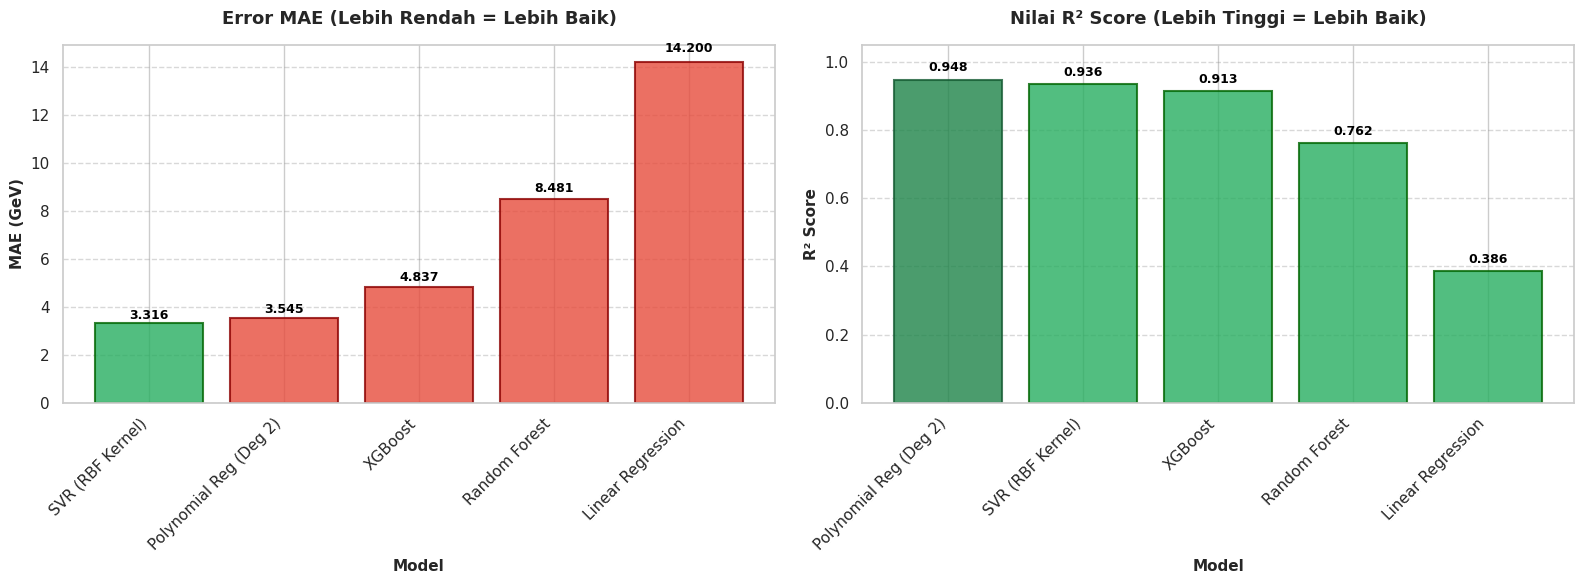


MODEL TERBAIK BERDASARKAN METRIK

MAE Terendah:
   Model    : SVR (RBF Kernel)
   MAE      : 3.3157
   R² Score : 0.9360

R² Score Tertinggi:
   Model    : Polynomial Reg (Deg 2)
   MAE      : 3.5448
   R² Score : 0.9481


In [17]:
print("\n=== PERINGKAT PERFORMA MODEL (DATA UJI) ===")

required_cols = ["Model", "MAE", "R2 Score"]

if not all(col in df_final.columns for col in required_cols):
    print(f"Error: df_final tidak memiliki kolom yang diperlukan. Kolom yang ada: {df_final.columns.tolist()}")
else:
    styled_final = df_final.style.format({
        "MAE": "{:.4f}",
        "R2 Score": "{:.4f}"
    })

    display(styled_final)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    error_color = '#E74C3C'
    accuracy_color = '#27AE60'

    df_sorted_mae = df_final.sort_values('MAE', ascending=True)

    bars1 = axes[0].bar(range(len(df_sorted_mae)),
                        df_sorted_mae["MAE"],
                        color=error_color,
                        alpha=0.8,
                        edgecolor='darkred',
                        linewidth=1.5)

    axes[0].set_title("Error MAE (Lebih Rendah = Lebih Baik)",
                      fontsize=13, fontweight='bold', pad=15)
    axes[0].set_xlabel("Model", fontsize=11, fontweight='bold')
    axes[0].set_ylabel("MAE (GeV)", fontsize=11, fontweight='bold')
    axes[0].set_xticks(range(len(df_sorted_mae)))
    axes[0].set_xticklabels(df_sorted_mae["Model"], rotation=45, ha='right')
    axes[0].grid(axis='y', linestyle='--', alpha=0.3, color='gray')
    axes[0].set_axisbelow(True)

    bars1[0].set_color('#27AE60')
    bars1[0].set_edgecolor('darkgreen')

    for i, (idx, row) in enumerate(df_sorted_mae.iterrows()):
        v = row["MAE"]
        axes[0].text(i, v + (v * 0.02), f"{v:.3f}",
                    ha='center', va='bottom',
                    color='black', fontweight='bold', fontsize=9)

    df_sorted_r2 = df_final.sort_values('R2 Score', ascending=False)

    bars2 = axes[1].bar(range(len(df_sorted_r2)),
                        df_sorted_r2["R2 Score"],
                        color=accuracy_color,
                        alpha=0.8,
                        edgecolor='darkgreen',
                        linewidth=1.5)

    axes[1].set_title("Nilai R² Score (Lebih Tinggi = Lebih Baik)",
                      fontsize=13, fontweight='bold', pad=15)
    axes[1].set_xlabel("Model", fontsize=11, fontweight='bold')
    axes[1].set_ylabel("R² Score", fontsize=11, fontweight='bold')
    axes[1].set_ylim(0, 1.05)
    axes[1].set_xticks(range(len(df_sorted_r2)))
    axes[1].set_xticklabels(df_sorted_r2["Model"], rotation=45, ha='right')
    axes[1].grid(axis='y', linestyle='--', alpha=0.3, color='gray')
    axes[1].set_axisbelow(True)

    bars2[0].set_color('#1E8449')
    bars2[0].set_edgecolor('#145A32')

    for i, (idx, row) in enumerate(df_sorted_r2.iterrows()):
        v = row["R2 Score"]
        axes[1].text(i, v + 0.015, f"{v:.3f}",
                    ha='center', va='bottom',
                    color='black', fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("MODEL TERBAIK BERDASARKAN METRIK")
    print("="*60)

    best_mae = df_final.loc[df_final['MAE'].idxmin()]
    best_r2 = df_final.loc[df_final['R2 Score'].idxmax()]

    print(f"\nMAE Terendah:")
    print(f"   Model    : {best_mae['Model']}")
    print(f"   MAE      : {best_mae['MAE']:.4f}")
    print(f"   R² Score : {best_mae['R2 Score']:.4f}")

    print(f"\nR² Score Tertinggi:")
    print(f"   Model    : {best_r2['Model']}")
    print(f"   MAE      : {best_r2['MAE']:.4f}")
    print(f"   R² Score : {best_r2['R2 Score']:.4f}")

    if best_mae['Model'] == best_r2['Model']:
        print(f"\n🏆 MODEL TERBAIK KESELURUHAN: {best_mae['Model']}")

    print("="*60)

## 7.3 Analisis Model Terbaik


ANALISIS MODEL TERBAIK: Polynomial Reg (Deg 2)
MAE      : 3.5448
R² Score : 0.9481



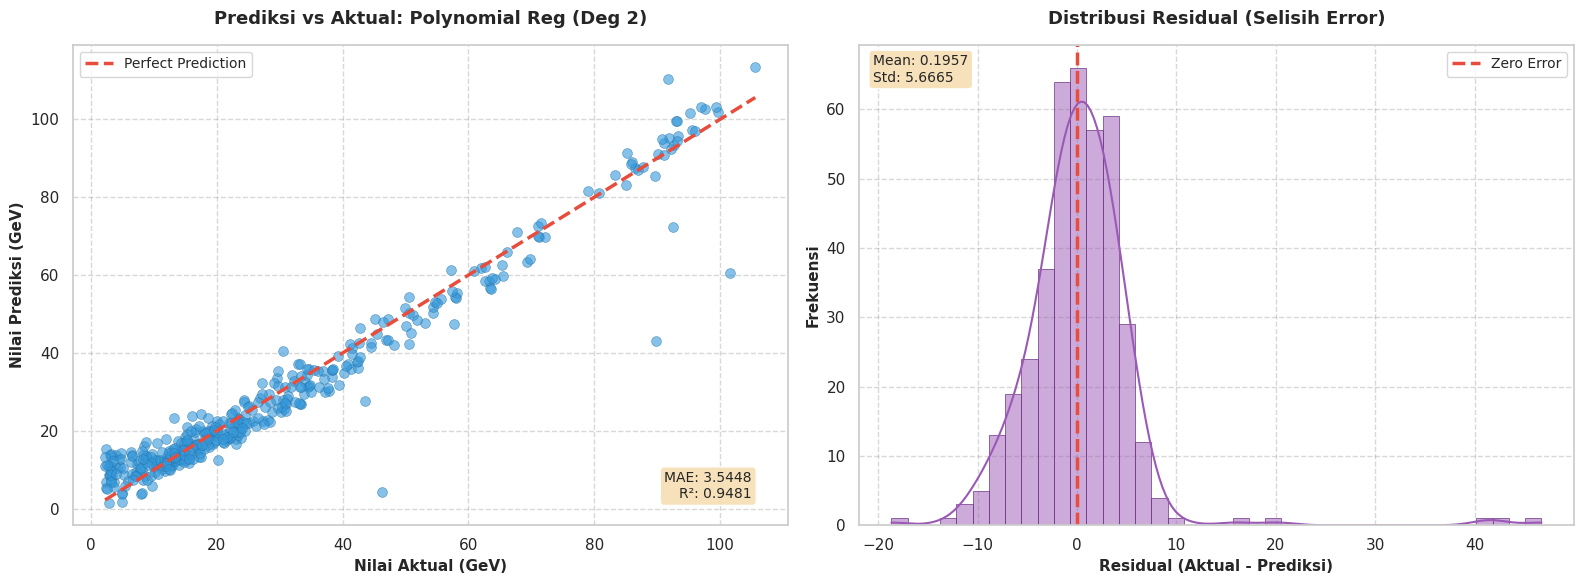


Statistik Residual:
  Mean Residual: 0.1957
  Std Residual : 5.6665
  Min Residual : -18.6590
  Max Residual : 46.7052


In [18]:
best_model_name = df_final.iloc[0]["Model"]
best_model_mae = df_final.iloc[0]["MAE"]
best_model_r2 = df_final.iloc[0]["R2 Score"]

best_model = trained_models[best_model_name]

y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

print(f"\n{'='*60}")
print(f"ANALISIS MODEL TERBAIK: {best_model_name}")
print(f"{'='*60}")
print(f"MAE      : {best_model_mae:.4f}")
print(f"R² Score : {best_model_r2:.4f}")
print(f"{'='*60}\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_test, y_pred_best, alpha=0.6, s=50, color='#3498DB', edgecolors='#2874A6', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='#E74C3C', linestyle='--', linewidth=2.5, label='Perfect Prediction')

axes[0].set_title(f"Prediksi vs Aktual: {best_model_name}", fontsize=13, fontweight='bold', pad=15)
axes[0].set_xlabel("Nilai Aktual (GeV)", fontsize=11, fontweight='bold')
axes[0].set_ylabel("Nilai Prediksi (GeV)", fontsize=11, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.3, color='gray')
axes[0].set_axisbelow(True)

stats_text_1 = f"MAE: {best_model_mae:.4f}\nR²: {best_model_r2:.4f}"
axes[0].text(0.95, 0.05, stats_text_1, transform=axes[0].transAxes,
             fontsize=10, verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

sns.histplot(residuals, bins=40, kde=True, color='#9B59B6', ax=axes[1], edgecolor='#6C3483', linewidth=0.5)
axes[1].axvline(0, color='#E74C3C', linestyle='--', linewidth=2.5, label='Zero Error')

axes[1].set_title("Distribusi Residual (Selisih Error)", fontsize=13, fontweight='bold', pad=15)
axes[1].set_xlabel("Residual (Aktual - Prediksi)", fontsize=11, fontweight='bold')
axes[1].set_ylabel("Frekuensi", fontsize=11, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.3, color='gray')
axes[1].set_axisbelow(True)

mean_residual = residuals.mean()
std_residual = residuals.std()
stats_text_2 = f"Mean: {mean_residual:.4f}\nStd: {std_residual:.4f}"
axes[1].text(0.02, 0.98, stats_text_2, transform=axes[1].transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='left',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

plt.tight_layout()
plt.show()

print("\nStatistik Residual:")
print(f"  Mean Residual: {mean_residual:.4f}")
print(f"  Std Residual : {std_residual:.4f}")
print(f"  Min Residual : {residuals.min():.4f}")
print(f"  Max Residual : {residuals.max():.4f}")

## 7.4 Performance Evaluation


ANALISIS FITTING STATUS (Berdasarkan MAE)

Perbandingan Performa Training vs Testing:


,Model,Train MAE,Test MAE,Gap MAE,Gap (%),Train R²,Test R²,Fit Status
0,Linear Regression,14.0628,14.1999,0.1371,0.97%,0.4181,0.3857,Underfit
1,Polynomial Reg (Deg 2),2.9869,3.5448,0.5579,18.68%,0.9784,0.9481,Good Fit
3,Random Forest,3.9960,8.4809,4.4848,112.23%,0.9490,0.7618,Overfit (Ekstrem)
2,SVR (RBF Kernel),1.3761,3.3157,1.9396,140.95%,0.9912,0.9360,Overfit (Ekstrem)
4,XGBoost,1.5649,4.8366,3.2717,209.07%,0.9928,0.9135,Overfit (Ekstrem)



INTERPRETASI FIT STATUS
Gap (%) = (Test MAE - Train MAE) / Train MAE × 100%

Klasifikasi Fit Status:
------------------------------------------------------------
1. UNDERFIT:
   - Train MAE tinggi (>10 GeV)
   - Test MAE tinggi (>10 GeV)
   - Gap kecil (<30%)
   - Interpretasi: Model terlalu sederhana, tidak menangkap pola data

2. GOOD FIT:
   - Train MAE rendah (<5 GeV)
   - Test MAE rendah (<5 GeV)
   - Gap kecil (<30%)
   - Interpretasi: Model generalisasi dengan baik

3. OVERFIT (Sedang):
   - Train MAE rendah (<5 GeV)
   - Test MAE moderat (5-10 GeV)
   - Gap sedang (30-100%)
   - Interpretasi: Model sedikit hafal training data, masih acceptable

4. OVERFIT (Tinggi/Ekstrem):
   - Train MAE sangat rendah (<3 GeV)
   - Test MAE tinggi (>8 GeV)
   - Gap besar (>100%)
   - Interpretasi: Model hafal training data, tidak reliable untuk data baru

DETAIL ANALISIS PER MODEL

Linear Regression:
  Train MAE       : 14.0628 GeV
  Test MAE        : 14.1999 GeV
  Gap             : 0.1371 GeV

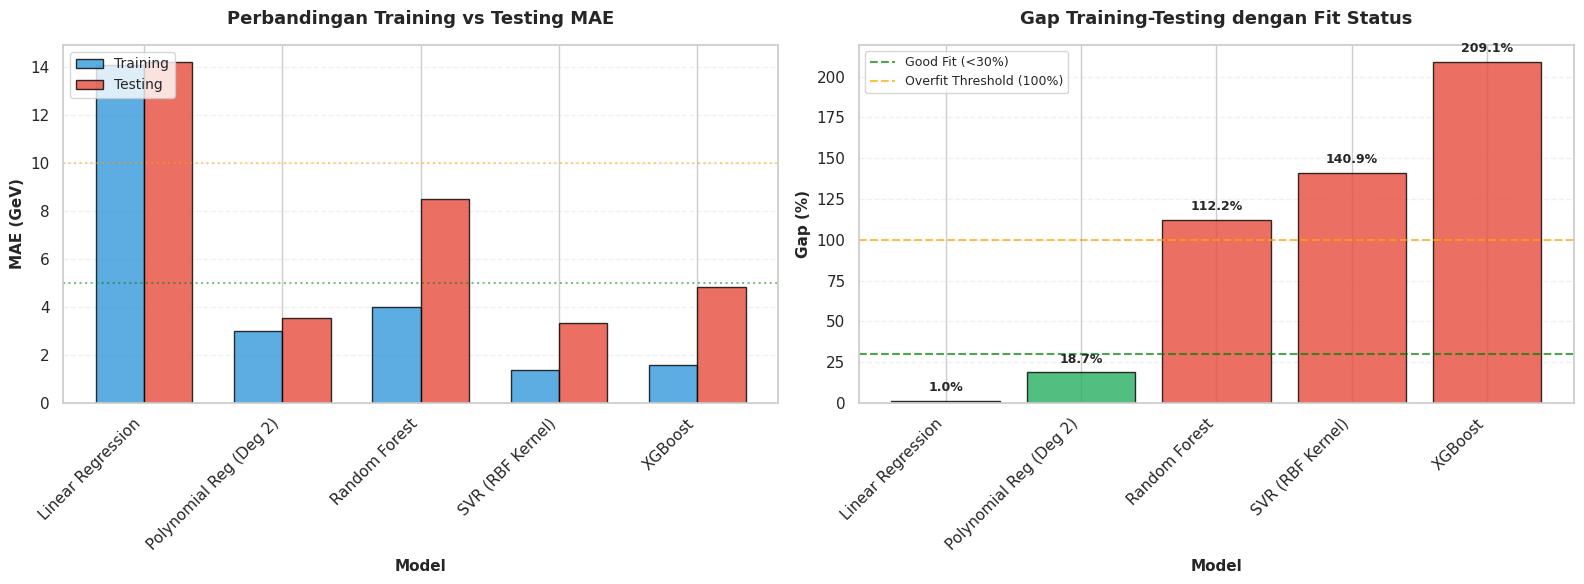


RINGKASAN FIT STATUS

Jumlah Model per Kategori:
  Overfit (Ekstrem): 3 model
  Underfit: 1 model
  Good Fit: 1 model

Model dengan Good Fit:
  - Polynomial Reg (Deg 2)

Model dengan Overfitting:
  - Random Forest (Overfit (Ekstrem))
  - SVR (RBF Kernel) (Overfit (Ekstrem))
  - XGBoost (Overfit (Ekstrem))

Model dengan Underfitting:
  - Linear Regression


In [19]:
print("\n" + "="*60)
print("ANALISIS FITTING STATUS (Berdasarkan MAE)")
print("="*60)

comparison_data = []

for name in trained_models.keys():
    train_data = next(item for item in training_scores if item['Model'] == name)
    test_data = next(item for item in final_results if item['Model'] == name)

    train_mae = train_data['Training MAE']
    test_mae = test_data['MAE']

    diff_mae = test_mae - train_mae

    if train_mae == 0:
        diff_pct = 0.0
    else:
        diff_pct = (diff_mae / train_mae) * 100

    train_r2 = train_data['Training R²']
    test_r2 = test_data['R2 Score']
    diff_r2 = train_r2 - test_r2

    mae_threshold_low = 5.0
    mae_threshold_high = 10.0
    gap_threshold = 30.0

    if train_mae > mae_threshold_high and test_mae > mae_threshold_high:
        fit_status = "Underfit"
        status_note = "Model terlalu sederhana, tidak belajar dengan baik"

    elif train_mae < mae_threshold_low and test_mae < mae_threshold_low and diff_pct < gap_threshold:
        fit_status = "Good Fit"
        status_note = "Model generalisasi dengan baik"

    elif train_mae < mae_threshold_low and diff_pct >= gap_threshold:
        fit_status = "Overfit"

        if diff_pct < 50:
            fit_status = "Overfit (Sedang)"
            status_note = "Overfitting moderat, masih dapat diterima"
        elif diff_pct < 100:
            fit_status = "Overfit (Tinggi)"
            status_note = "Overfitting signifikan, perlu regularisasi"
        else:
            fit_status = "Overfit (Ekstrem)"
            status_note = "Model hafal training data, tidak reliable"
    else:
        if diff_pct < gap_threshold:
            fit_status = "Good Fit"
            status_note = "Performa seimbang antara training dan testing"
        else:
            fit_status = "Overfit (Sedang)"
            status_note = "Slight overfitting, dapat ditingkatkan"

    comparison_data.append({
        'Model': name,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Gap MAE': diff_mae,
        'Gap (%)': diff_pct,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Gap R²': diff_r2,
        'Fit Status': fit_status,
        'Keterangan': status_note
    })

df_comparison = pd.DataFrame(comparison_data).sort_values('Gap (%)', ascending=True)

print("\nPerbandingan Performa Training vs Testing:")
print("="*60)

styled_comparison = df_comparison[['Model', 'Train MAE', 'Test MAE', 'Gap MAE',
                                    'Gap (%)', 'Train R²', 'Test R²', 'Fit Status']].style.format({
    'Train MAE': '{:.4f}',
    'Test MAE': '{:.4f}',
    'Gap MAE': '{:.4f}',
    'Gap (%)': '{:.2f}%',
    'Train R²': '{:.4f}',
    'Test R²': '{:.4f}'
})

display(styled_comparison)

print("\n" + "="*60)
print("INTERPRETASI FIT STATUS")
print("="*60)
print("Gap (%) = (Test MAE - Train MAE) / Train MAE × 100%")
print("\nKlasifikasi Fit Status:")
print("-" * 60)
print("1. UNDERFIT:")
print("   - Train MAE tinggi (>10 GeV)")
print("   - Test MAE tinggi (>10 GeV)")
print("   - Gap kecil (<30%)")
print("   - Interpretasi: Model terlalu sederhana, tidak menangkap pola data")
print()
print("2. GOOD FIT:")
print("   - Train MAE rendah (<5 GeV)")
print("   - Test MAE rendah (<5 GeV)")
print("   - Gap kecil (<30%)")
print("   - Interpretasi: Model generalisasi dengan baik")
print()
print("3. OVERFIT (Sedang):")
print("   - Train MAE rendah (<5 GeV)")
print("   - Test MAE moderat (5-10 GeV)")
print("   - Gap sedang (30-100%)")
print("   - Interpretasi: Model sedikit hafal training data, masih acceptable")
print()
print("4. OVERFIT (Tinggi/Ekstrem):")
print("   - Train MAE sangat rendah (<3 GeV)")
print("   - Test MAE tinggi (>8 GeV)")
print("   - Gap besar (>100%)")
print("   - Interpretasi: Model hafal training data, tidak reliable untuk data baru")

print("\n" + "="*60)
print("DETAIL ANALISIS PER MODEL")
print("="*60)

for idx, row in df_comparison.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  Train MAE       : {row['Train MAE']:.4f} GeV")
    print(f"  Test MAE        : {row['Test MAE']:.4f} GeV")
    print(f"  Gap             : {row['Gap MAE']:.4f} GeV ({row['Gap (%)']:.2f}%)")
    print(f"  Train R²        : {row['Train R²']:.4f}")
    print(f"  Test R²         : {row['Test R²']:.4f}")
    print(f"  Fit Status      : {row['Fit Status']}")
    print(f"  Interpretasi    : {row['Keterangan']}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models_list = df_comparison['Model'].tolist()
train_mae_list = df_comparison['Train MAE'].tolist()
test_mae_list = df_comparison['Test MAE'].tolist()

x = np.arange(len(models_list))
width = 0.35

bars1 = axes[0].bar(x - width/2, train_mae_list, width, label='Training',
                    color='#3498DB', alpha=0.8, edgecolor='black', linewidth=1)
bars2 = axes[0].bar(x + width/2, test_mae_list, width, label='Testing',
                    color='#E74C3C', alpha=0.8, edgecolor='black', linewidth=1)

axes[0].set_xlabel('Model', fontsize=11, fontweight='bold')
axes[0].set_ylabel('MAE (GeV)', fontsize=11, fontweight='bold')
axes[0].set_title('Perbandingan Training vs Testing MAE', fontsize=13, fontweight='bold', pad=15)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_list, rotation=45, ha='right')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.3)
axes[0].set_axisbelow(True)

axes[0].axhline(y=5, color='green', linestyle=':', linewidth=1.5, alpha=0.5, label='Good MAE (<5)')
axes[0].axhline(y=10, color='orange', linestyle=':', linewidth=1.5, alpha=0.5, label='Poor MAE (>10)')

gap_pct = df_comparison['Gap (%)'].tolist()
fit_statuses = df_comparison['Fit Status'].tolist()

colors = []
for status in fit_statuses:
    if status == "Underfit":
        colors.append('#95A5A6')
    elif status == "Good Fit":
        colors.append('#27AE60')
    elif "Sedang" in status:
        colors.append('#F39C12')
    elif "Tinggi" in status or "Ekstrem" in status:
        colors.append('#E74C3C')
    else:
        colors.append('#3498DB')

bars3 = axes[1].bar(models_list, gap_pct, color=colors, alpha=0.8,
                    edgecolor='black', linewidth=1)

axes[1].set_xlabel('Model', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Gap (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Gap Training-Testing dengan Fit Status', fontsize=13, fontweight='bold', pad=15)
axes[1].set_xticklabels(models_list, rotation=45, ha='right')

axes[1].axhline(y=30, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Good Fit (<30%)')
axes[1].axhline(y=100, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Overfit Threshold (100%)')
axes[1].legend(loc='upper left', fontsize=9)
axes[1].grid(axis='y', linestyle='--', alpha=0.3)
axes[1].set_axisbelow(True)

for i, v in enumerate(gap_pct):
    axes[1].text(i, v + (max(gap_pct) * 0.02), f'{v:.1f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("RINGKASAN FIT STATUS")
print("="*60)

fit_status_counts = df_comparison['Fit Status'].value_counts()
print("\nJumlah Model per Kategori:")
for status, count in fit_status_counts.items():
    print(f"  {status}: {count} model")

print("\nModel dengan Good Fit:")
good_fit_models = df_comparison[df_comparison['Fit Status'] == 'Good Fit']['Model'].tolist()
if good_fit_models:
    for model in good_fit_models:
        print(f"  - {model}")
else:
    print("  (Tidak ada)")

print("\nModel dengan Overfitting:")
overfit_models = df_comparison[df_comparison['Fit Status'].str.contains('Overfit')]['Model'].tolist()
if overfit_models:
    for model in overfit_models:
        status = df_comparison[df_comparison['Model'] == model]['Fit Status'].values[0]
        print(f"  - {model} ({status})")
else:
    print("  (Tidak ada)")

print("\nModel dengan Underfitting:")
underfit_models = df_comparison[df_comparison['Fit Status'] == 'Underfit']['Model'].tolist()
if underfit_models:
    for model in underfit_models:
        print(f"  - {model}")
else:
    print("  (Tidak ada)")

print("="*60)